你的推理过程（我帮你理清一下）

目标变量

你最终关心的是 地图复杂度 Complexity

但 Complexity 不能直接观测（它只是一个潜在概念/指标）

我们能观测到的结果是 success_rate（训练表现）

核心假设

success_rate 越低 → 地图越难（Complexity 越高）

success_rate 越高 → 地图越简单（Complexity 越低）

所以：Complexity 是 success_rate 的函数。

学习流程

Step 1. 用 XGBoost 学习 success_rate ~ 特征(size, agents, density, LDD, BN, MC, DLR, ...) 的非线性关系

Step 2. 提取特征重要性（说明哪些特征最影响 success_rate → 哪些特征决定复杂度）

Step 3. 把 XGBoost 的非线性结果转化成线性权重公式

In [14]:
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 读数据
df = pd.read_csv("C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv")

# 特征 & 目标
features = ["size", "num_agents", "density", "density_actual", "LDD", "BN", "MC", "DLR", "FPA", "FRA"]
X = df[features]
y = df["success_rate"]

# Step 1: 用 XGBoost 学 success_rate
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X, y)

# Step 2: 特征重要性
importance = pd.DataFrame({
    "feature": features,
    "importance": xgb_model.feature_importances_
}).sort_values("importance", ascending=False)

print("📊 特征重要性 (对 success_rate 的影响)：")
print(importance)

# Step 3: 转化成线性权重（拟合可解释公式）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lr = LinearRegression().fit(X_scaled, y)

weights = pd.DataFrame({
    "feature": features,
    "weight": lr.coef_
}).sort_values("weight", ascending=False)

print("\n📊 线性权重 (可解释公式)：")
print(weights)

# Step 4: Complexity = 1 - success_rate
# 你也可以直接用 1 - success_rate 或者把 success_rate 回归结果反转
df["Complexity"] = 1 - y

print("\n公式：")
print("Complexity = {:.3f} + ".format(lr.intercept_) +
      " + ".join(f"({w:.3f} * {f})" for f, w in zip(features, lr.coef_)))


📊 特征重要性 (对 success_rate 的影响)：
          feature  importance
8             FPA    0.291223
9             FRA    0.159911
2         density    0.113648
5              BN    0.106351
3  density_actual    0.095563
6              MC    0.061285
4             LDD    0.051889
1      num_agents    0.044743
7             DLR    0.042149
0            size    0.033238

📊 线性权重 (可解释公式)：
          feature    weight
3  density_actual  0.094523
6              MC  0.033021
4             LDD  0.021963
0            size  0.021643
7             DLR  0.003857
2         density -0.003044
1      num_agents -0.010270
9             FRA -0.024654
8             FPA -0.058766
5              BN -0.092417

公式：
Complexity = 0.848 + (0.022 * size) + (-0.010 * num_agents) + (-0.003 * density) + (0.095 * density_actual) + (0.022 * LDD) + (-0.092 * BN) + (0.033 * MC) + (0.004 * DLR) + (-0.059 * FPA) + (-0.025 * FRA)


In [15]:
# ================================
# XGBoost 特征学习 + 可视化 + 权重提取 + 线性公式
# ================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# ---------- 0) 参数 ----------
# === 你的原始配置 ===
CSV_PATH = r"C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv"
OUTDIR   = r"C:/Users/MSc_SEIoT_1/Desktop/pic"

# === 统一用 Path，确保目录存在 ===
OUTDIR = Path(OUTDIR)
OUTDIR.mkdir(parents=True, exist_ok=True)

def out_path(name: str) -> Path:
    return OUTDIR / name

def norm(p: Path) -> str:
    # 打印时一律用正斜杠
    return p.as_posix()

# 使用到的特征与目标
FEATURES = ["size", "num_agents", "density", "density_actual", "LDD", "BN", "MC", "DLR", "FPA", "FRA"]
TARGET   = "success_rate"  # 首选目标

# ---------- 1) 读数据 & 清洗 ----------
df = pd.read_csv(CSV_PATH, engine="python")

# 强制转数值
for col in FEATURES + [TARGET]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 选择目标：优先 success_rate；如果全无效，回退到 Complexity proxy
use_success = False
if TARGET in df.columns:
    y_ok = df[TARGET].notna() & np.isfinite(df[TARGET]) & (df[TARGET] >= 0) & (df[TARGET] <= 1)
    if int(y_ok.sum()) > 0:
        use_success = True
        y = df.loc[y_ok, TARGET]
        X = df.loc[y_ok, FEATURES]
    else:
        y = df[["LDD", "BN", "MC", "DLR", "FPA", "FRA"]].mean(axis=1)
        X = df[FEATURES]
else:
    y = df[["LDD", "BN", "MC", "DLR", "FPA", "FRA"]].mean(axis=1)
    X = df[FEATURES]

# 特征用中位数补缺，保证稳定绘图
X = X.fillna(X.median(numeric_only=True))

# ---------- 2) 划分数据 ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------- 3) 训练 XGBoost ----------
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42
)
xgb_model.fit(X_train, y_train)

# ---------- 4) 评估 ----------
y_pred_tr = xgb_model.predict(X_train)
y_pred_te = xgb_model.predict(X_test)

r2_tr = r2_score(y_train, y_pred_tr)
r2_te = r2_score(y_test, y_pred_te)
rmse_te = mean_squared_error(y_test, y_pred_te, squared=False)
mae_te = mean_absolute_error(y_test, y_pred_te)

print(f"Target = {'success_rate' if use_success else 'Complexity proxy (mean of LDD/BN/MC/DLR)'}")
print(f"R^2 train = {r2_tr:.3f}, R^2 test = {r2_te:.3f}, RMSE test = {rmse_te:.4f}, MAE test = {mae_te:.4f}")

# ---------- 5) 内置特征重要性 ----------
imp_df = pd.DataFrame({
    "feature": FEATURES,
    "importance": xgb_model.feature_importances_
}).sort_values("importance", ascending=True)

plt.figure(figsize=(7, 4.5))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance" + (" (success_rate)" if use_success else " (Complexity proxy)"))
plt.tight_layout()
fi_path = os.path.join(OUTDIR, "xgb_feature_importance.png")
plt.savefig(fi_path)
plt.close()

# ---------- 6) Permutation Importance（测试集，更稳健） ----------
pi = permutation_importance(
    xgb_model, X_test, y_test, n_repeats=15, random_state=42, n_jobs=1
)
pi_df = pd.DataFrame({
    "feature": FEATURES,
    "perm_importance": pi.importances_mean,
    "perm_std": pi.importances_std
}).sort_values("perm_importance", ascending=True)

plt.figure(figsize=(7, 4.5))
plt.barh(pi_df["feature"], pi_df["perm_importance"])
plt.xlabel("Permutation Importance (mean)")
plt.title("Permutation Importance on Test Set")
plt.tight_layout()
pi_path = os.path.join(OUTDIR, "permutation_importance.png")
plt.savefig(pi_path)
plt.close()

# ---------- 7) 预测 vs 实际 ----------
xy_min = float(min(y_test.min(), y_pred_te.min()))
xy_max = float(max(y_test.max(), y_pred_te.max()))

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_te, s=16)
plt.plot([xy_min, xy_max], [xy_min, xy_max])
plt.xlabel("Actual")
plt.ylabel("Predicted")
ttl = "Predicted vs Actual (XGBoost)"
ttl += f"\nR²={r2_te:.3f}, RMSE={rmse_te:.3f}, MAE={mae_te:.3f}"
plt.title(ttl)
plt.tight_layout()
pva_path = os.path.join(OUTDIR, "pred_vs_actual.png")
plt.savefig(pva_path)
plt.close()

# ---------- 8) 残差图 ----------
residuals = y_test - y_pred_te
plt.figure(figsize=(7, 4))
plt.scatter(y_pred_te, residuals, s=12)
plt.axhline(0)
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Pred)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
rvp_path = os.path.join(OUTDIR, "residuals_vs_pred.png")
plt.savefig(rvp_path)
plt.close()

# 残差直方图
plt.figure(figsize=(7, 4))
plt.hist(residuals, bins=20)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residuals Histogram")
plt.tight_layout()
rhist_path = os.path.join(OUTDIR, "residuals_hist.png")
plt.savefig(rhist_path)
plt.close()

# ---------- 9) 前 3 特征的 PDP ----------
top3 = list(imp_df.sort_values("importance", ascending=False)["feature"][:3])
baseline = X_train.median(numeric_only=True)
pdp_paths = []

for f in top3:
    f_min, f_max = X_train[f].min(), X_train[f].max()
    grid = np.linspace(f_min, f_max, 70)

    # 基线为各特征中位数，仅改变一个特征 f
    X_grid = np.repeat(baseline.values.reshape(1, -1), len(grid), axis=0)
    X_grid = pd.DataFrame(X_grid, columns=FEATURES)
    X_grid[f] = grid

    preds = xgb_model.predict(X_grid)

    plt.figure(figsize=(7, 4))
    plt.plot(grid, preds)
    plt.xlabel(f)
    plt.ylabel("Predicted " + ("success_rate" if use_success else "Complexity proxy"))
    plt.title("Partial Dependence: " + f)
    plt.tight_layout()
    outp = os.path.join(OUTDIR, f"pdp_{f}.png")
    plt.savefig(outp)
    plt.close()
    pdp_paths.append(outp)

# ---------- 10) 基于 Permutation Importance 的“Complexity 权重” ----------
# 若有负值（噪声造成的），裁剪为0后再归一化
pi_pos = pi_df.copy()
pi_pos["perm_importance_clipped"] = pi_pos["perm_importance"].clip(lower=0)
total = pi_pos["perm_importance_clipped"].sum()
if total == 0:
    # 如果全是0，退化为等权
    pi_pos["weight_norm"] = 1.0 / len(pi_pos)
else:
    pi_pos["weight_norm"] = pi_pos["perm_importance_clipped"] / total

# 为了直观展示“对复杂度的贡献”，我们通常让“成功率的负相关特征”获得正的复杂度权重。
# 这里简单做一个符号翻转：如果 XGBoost 的 SHAP 或方向没有估，先给出无方向的正权重（用在加权综合上）。
# 你也可以后续用 SHAP 判断方向，再给权重加 +/- 号。
weights_csv = os.path.join(OUTDIR, "complexity_weights_from_PI.csv")
pi_pos[["feature", "weight_norm"]].sort_values("weight_norm", ascending=False).to_csv(weights_csv, index=False)

print("\n=== Complexity 权重（基于 Permutation Importance 归一化） ===")
print(pi_pos[["feature", "weight_norm"]].sort_values("weight_norm", ascending=False))

# ---------- 11) 线性可解释公式（模型蒸馏） ----------
# 用 XGBoost 的预测作为 teacher target，对标准化特征做线性回归，得到可解释公式
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_train)
X_te_scaled = scaler.transform(X_test)

teacher_tr = xgb_model.predict(X_train)
teacher_te = xgb_model.predict(X_test)

lin = LinearRegression().fit(X_tr_scaled, teacher_tr)
coef = lin.coef_
intercept = lin.intercept_

formula = "ŷ = {:.6f} + ".format(intercept) + " + ".join(
    f"({w:+.6f}·{name}_z)" for w, name in zip(coef, FEATURES)
)

print("\n=== 线性可解释“蒸馏”公式（输入为标准化后的 z 分数） ===")
print(formula)

# 保存线性系数
coef_df = pd.DataFrame({"feature": FEATURES, "coef_on_z": coef})
coef_path = os.path.join(OUTDIR, "linear_surrogate_coeffs.csv")
coef_df.sort_values("coef_on_z", ascending=False).to_csv(coef_path, index=False)

# # ---------- 12) 路径汇总 ----------

# === 用法示例（保存 & 打印）===
fig_imp_path   = out_path("xgb_feature_importance.png")
perm_imp_path  = out_path("permutation_importance.png")
pred_act_path  = out_path("pred_vs_actual.png")
resid_pred_path= out_path("residuals_vs_pred.png")
resid_hist_path= out_path("residuals_hist.png")
pdp_mc_path    = out_path("pdp_MC.png")
pdp_den_path   = out_path("pdp_density.png")
pdp_ldd_path   = out_path("pdp_LDD.png")
w_csv_path     = out_path("complexity_weights_from_PI.csv")
lin_csv_path   = out_path("linear_surrogate_coeffs.csv")

# 保存图片/CSV 时：
# plt.savefig(fig_imp_path)  # 其余同理
# df.to_csv(w_csv_path, index=False, encoding="utf-8-sig")

# 打印时（统一格式）
print("Feature importance:",          norm(fig_imp_path))
print("Permutation importance:",      norm(perm_imp_path))
print("Pred vs Actual:",              norm(pred_act_path))
print("Residuals vs Pred:",           norm(resid_pred_path))
print("Residuals histogram:",         norm(resid_hist_path))
print("PDP (top 3):",                 norm(pdp_mc_path)+",", norm(pdp_den_path)+",", norm(pdp_ldd_path))
print("Complexity 权重 CSV:",          norm(w_csv_path))
print("线性系数 CSV:",                 norm(lin_csv_path))
# print("\n=== 输出文件 ===")
# print("Feature importance:", fi_path)
# print("Permutation importance:", pi_path)
# print("Pred vs Actual:", pva_path)
# print("Residuals vs Pred:", rvp_path)
# print("Residuals histogram:", rhist_path)
# print("PDP (top 3):", ", ".join(pdp_paths))
# print("Complexity 权重 CSV:", weights_csv)
# print("线性系数 CSV:", coef_path)


Target = success_rate
R^2 train = 0.932, R^2 test = 0.707, RMSE test = 0.0563, MAE test = 0.0443

=== Complexity 权重（基于 Permutation Importance 归一化） ===
          feature  weight_norm
8             FPA     0.803973
9             FRA     0.104439
3  density_actual     0.056986
6              MC     0.017920
2         density     0.016682
7             DLR     0.000000
1      num_agents     0.000000
5              BN     0.000000
0            size     0.000000
4             LDD     0.000000

=== 线性可解释“蒸馏”公式（输入为标准化后的 z 分数） ===
ŷ = 0.849580 + (+0.030194·size_z) + (-0.005511·num_agents_z) + (+0.052293·density_z) + (+0.172724·density_actual_z) + (+0.029522·LDD_z) + (-0.170371·BN_z) + (+0.042245·MC_z) + (+0.001388·DLR_z) + (+0.001722·FPA_z) + (-0.025867·FRA_z)
Feature importance: C:/Users/MSc_SEIoT_1/Desktop/pic/xgb_feature_importance.png
Permutation importance: C:/Users/MSc_SEIoT_1/Desktop/pic/permutation_importance.png
Pred vs Actual: C:/Users/MSc_SEIoT_1/Desktop/pic/pred_vs_actual.png
Residu

In [16]:
# 基础依赖
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 模型和工具
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

# 修改成你的CSV路径
CSV_PATH = "C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv"

df = pd.read_csv(CSV_PATH)
print("Data loaded:", df.shape)
print(df.head())


Data loaded: (122, 19)
        algo  stage_idx      config_id  \
0  CL-Gray3D          0  sz32_a2_d0.10   
1  CL-Gray3D          0  sz32_a2_d0.10   
2  CL-Gray3D          1  sz32_a2_d0.30   
3  CL-Gray3D          2  sz32_a2_d0.50   
4  CL-Gray3D          3  sz32_a2_d0.70   

                                         config_json  size  num_agents  \
0  {"size":32,"obs_radius":5,"density":0.1,"num_a...    32           2   
1  {"max_episode_steps":100,"size":32,"density":0...    32           2   
2  {"max_episode_steps":100,"size":32,"density":0...    32           2   
3  {"max_episode_steps":100,"size":32,"density":0...    32           2   
4  {"max_episode_steps":100,"size":32,"density":0...    32           2   

   density  obs_radius  max_episode_steps  density_actual       LDD        BN  \
0      0.1           5                100        0.207031  0.030569  0.094828   
1      0.1           5                100        0.207031  0.030569  0.094828   
2      0.3           5              

In [17]:
# 目标列（复杂度 / 成功率）
TARGET_COL = "success_rate"   # 或者 "Complexity"，看你的数据

# 候选特征（根据你的 CSV 调整）
FEATURES = [
    "size", "num_agents", "density", "density_actual",
    "LDD", "BN", "MC", "DLR", "FPA", "FRA"
]

# 保留实际存在的特征
features = [f for f in FEATURES if f in df.columns]
print("Using features:", features)

X = df[features].fillna(0).values
y = df[TARGET_COL].values


Using features: ['size', 'num_agents', 'density', 'density_actual', 'LDD', 'BN', 'MC', 'DLR', 'FPA', 'FRA']


In [18]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 标准化（防止特征尺度差异影响线性模型）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print("原始维度:", X_train_scaled.shape, " -> 加入交互后:", X_train_poly.shape)


原始维度: (97, 10)  -> 加入交互后: (97, 55)


In [20]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001)
}

for name, model in models.items():
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    print(f"{name}: R²={r2_score(y_test, y_pred):.3f}, "
          f"RMSE={mean_squared_error(y_test, y_pred, squared=False):.3f}, "
          f"MAE={mean_absolute_error(y_test, y_pred):.3f}")


Linear: R²=0.538, RMSE=0.071, MAE=0.055
Ridge: R²=0.755, RMSE=0.051, MAE=0.040
Lasso: R²=0.722, RMSE=0.055, MAE=0.042


In [21]:
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

print("XGBoost: R²=%.3f, RMSE=%.3f, MAE=%.3f" % (
    r2_score(y_test, y_pred_xgb),
    mean_squared_error(y_test, y_pred_xgb, squared=False),
    mean_absolute_error(y_test, y_pred_xgb)
))


XGBoost: R²=0.700, RMSE=0.057, MAE=0.045


In [24]:
# Cell 1: imports & data loading
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# xgboost
from xgboost import XGBRegressor

# 你的数据路径（修改为实际路径）
CSV_PATH = r"C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv"

df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH)
print("Columns:", list(df.columns))
print("Shape:", df.shape)

# 目标列（按你的场景改：success_rate / Complexity / ...）
TARGET_COL = "success_rate"   # ← 如果是别的列名，改这里


Loaded: C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv
Columns: ['algo', 'stage_idx', 'config_id', 'config_json', 'size', 'num_agents', 'density', 'obs_radius', 'max_episode_steps', 'density_actual', 'LDD', 'BN', 'MC', 'DLR', 'success_rate', 'grid_hash', 'episodes_per_stage', 'FRA', 'FPA']
Shape: (122, 19)


In [25]:
# Cell 2: feature selection
# 如果你已经有 FEATURE_COLS，就直接设定；否则自动从数值列里排除目标列
FEATURE_COLS = None  # ← 若已有固定特征列表，例如 ["size","num_agents","density",...]，直接设为该列表

if FEATURE_COLS is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    FEATURE_COLS = [c for c in numeric_cols if c != TARGET_COL]

print("Using target:", TARGET_COL)
print("Using features:", FEATURE_COLS)

# 丢掉缺失
data = df.dropna(subset=[TARGET_COL] + FEATURE_COLS).copy()
X = data[FEATURE_COLS].values
y = data[TARGET_COL].astype(float).values

print("Final dataset shape:", X.shape, y.shape)


Using target: success_rate
Using features: ['stage_idx', 'size', 'num_agents', 'density', 'obs_radius', 'max_episode_steps', 'density_actual', 'LDD', 'BN', 'MC', 'DLR', 'episodes_per_stage', 'FRA', 'FPA']
Final dataset shape: (122, 14) (122,)


In [26]:
# Cell 3: train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    shuffle=True,
)
X_train.shape, X_test.shape


((91, 14), (31, 14))

In [27]:
# Cell 4: parameter grid and GridSearchCV
# 一个“中等规模”的搜索网格（运行速度 vs 效果平衡）
param_grid = {
    "n_estimators":     [200, 400, 800],
    "max_depth":        [3, 5, 7],
    "learning_rate":    [0.03, 0.05, 0.1],
    "subsample":        [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "min_child_weight": [1, 3, 5],
    "reg_alpha":        [0.0, 0.001, 0.01],
    "reg_lambda":       [1.0, 5.0, 10.0],
}

# 可选更大范围（性能足够时开启）
# param_grid["n_estimators"] = [400, 800, 1200]
# param_grid["max_depth"] = [3, 5, 7, 9]
# param_grid["learning_rate"] = [0.02, 0.05, 0.1]
# param_grid["subsample"] = [0.6, 0.8, 1.0]
# param_grid["colsample_bytree"] = [0.6, 0.8, 1.0]

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist",   # GPU可用时用 "gpu_hist"
    n_jobs=-1
)

# 多指标；以 R^2 作为最终 refit
cv = KFold(n_splits=5, shuffle=True, random_state=42)
search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring={"r2": "r2", "neg_mae": "neg_mean_absolute_error"},
    refit="r2",
    cv=cv,
    verbose=1,
    n_jobs=-1,
)

search


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.9, 1.0],
                         'learning_rate': [0.03, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [200, 400, 800],
                         'reg_alpha': [0.0, 0.001, 0.01],
                         'reg_lambda': [1.0, 5.0, 10.0],
                         'subsample': [0.7, 0.9, 1.0]},
             refit='r2',
             scoring={'neg_mae': 'neg_mean_absolute_error', 'r2': 'r2'},
             verbose=1)

In [28]:
# Cell 5: run search
search.fit(X_train, y_train)

print("Best R^2 (cv):", search.best_score_)
print("Best params:", search.best_params_)


Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
Best R^2 (cv): 0.6536045831802713
Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.001, 'reg_lambda': 1.0, 'subsample': 1.0}


In [29]:
# Cell 6: evaluate on test
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
r2  = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)

print(f"Test R^2={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")


Test R^2=0.747, RMSE=0.054, MAE=0.044


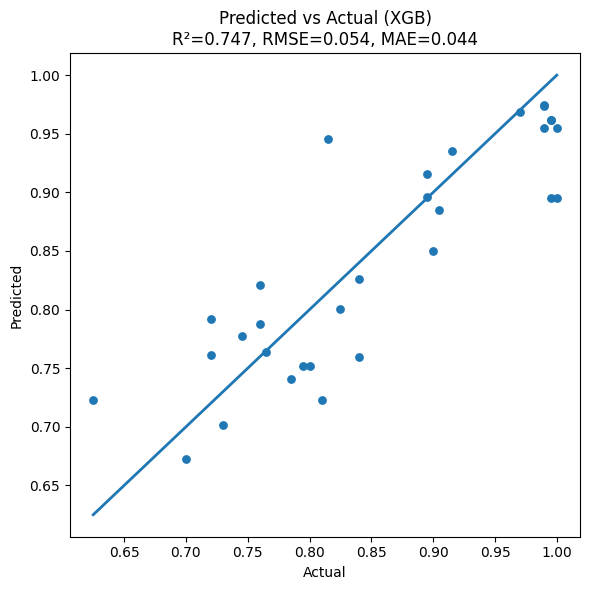

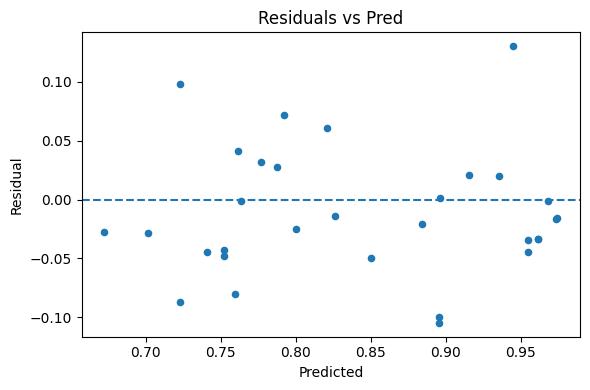

In [30]:
# Cell 7: plots
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=28)
mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
xs = np.linspace(mn, mx, 100)
plt.plot(xs, xs, linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Predicted vs Actual (XGB)\nR²={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
res = y_pred - y_test
plt.scatter(y_pred, res, s=20)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Pred")
plt.tight_layout()
plt.show()


继续优化Optuna 自动调参 + 特征交互生成

In [2]:
# 改成你的 CSV 路径 & 输出目录
# 如果你的环境里已经装了 optuna 和 xgboost，可以跳过 pip 安装行
# !pip install -U optuna xgboost scikit-learn matplotlib

import os
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import optuna
from optuna.integration import XGBoostPruningCallback
from optuna.samplers import TPESampler

from xgboost import XGBRegressor

CSV_PATH = r"C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv"
OUTDIR   = r"C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/pic_optuna"
os.makedirs(OUTDIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# 目标列（按你的数据改：成功率/复杂度等）
TARGET_COL = "success_rate"  # 或 "success_rate"
if TARGET_COL not in df.columns:
    raise ValueError(f"找不到目标列 {TARGET_COL}，请检查 CSV。")

# 基础特征列（来自你之前的公式；按实际 CSV 列名调整）
BASE_FEATURES = [
    "size","num_agents","density","density_actual",
    "LDD","BN","MC","DLR",
    # 可选：如果你 CSV 已计算了 FPA/FRA 就加上
    *([c for c in ["FRA","FPA"] if c in df.columns])
]

FEATURES = [c for c in BASE_FEATURES if c in df.columns]
if not FEATURES:
    raise ValueError("FEATURES 为空，请检查列名。")
print("Using features:", FEATURES)

# 丢 NA
df = df.dropna(subset=[TARGET_COL] + FEATURES).reset_index(drop=True)

y = df[TARGET_COL].astype(float).values
X_base = df[FEATURES].copy()


Loaded: C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/train_gray3d-Copy-FDA.csv
Shape: (122, 19)
Columns: ['algo', 'stage_idx', 'config_id', 'config_json', 'size', 'num_agents', 'density', 'obs_radius', 'max_episode_steps', 'density_actual', 'LDD', 'BN', 'MC', 'DLR', 'success_rate', 'grid_hash', 'episodes_per_stage', 'FRA', 'FPA']
Using features: ['size', 'num_agents', 'density', 'density_actual', 'LDD', 'BN', 'MC', 'DLR', 'FRA', 'FPA']


In [3]:
def build_interactions(df_in: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
    df = df_in.copy()

    cols = df.columns.tolist()

    # 一次项的稳定变换
    for c in cols:
        if (df[c] > 0).all():              # 只对正值做对数
            df[f"log_{c}"] = np.log(df[c] + eps)
        df[f"sqr_{c}"] = df[c] ** 2

    # 两两乘积
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            ci, cj = cols[i], cols[j]
            df[f"{ci}*{cj}"] = df[ci] * df[cj]

    # 有意义的比值（只对“规模/人数/密度系”做）
    ratio_candidates = [c for c in cols if any(k in c for k in ["size","agents","density","LDD","BN","MC","DLR","FRA","FPA"])]
    for i in range(len(ratio_candidates)):
        for j in range(len(ratio_candidates)):
            if i == j: 
                continue
            ci, cj = ratio_candidates[i], ratio_candidates[j]
            denom = df[cj].replace(0, np.nan).fillna(eps)
            df[f"{ci}_over_{cj}"] = df[ci] / denom

    return df

X_full = build_interactions(X_base)
print("Base dim:", X_base.shape, " -> With interactions:", X_full.shape)

# 为了可控，你也可以先只用一部分交互（例如选前 N 列强相关的）
X = X_full.copy()


Base dim: (122, 10)  -> With interactions: (122, 165)


In [4]:
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=RANDOM_SEED
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (97, 165) Test: (25, 165)


In [1]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 20.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": RANDOM_SEED,
        "tree_method": "hist",
        "n_jobs": max(1, os.cpu_count()-1),
        "eval_metric": "rmse",   # 评估指标放到**参数**里
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    rmses = []

    for tr_idx, va_idx in kf.split(X_train):
        X_tr, X_va = X_train[tr_idx], X_train[va_idx]
        y_tr, y_va = y_train[tr_idx], y_train[va_idx]

        model = XGBRegressor(**params)
        # 老版本 fit 不能带 early_stopping_rounds/callbacks
        model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, pred, squared=False)
        rmses.append(rmse)

    return float(np.mean(rmses))


In [5]:
# ===== Optuna：搜索 & 保存最优参数 =====
import numpy as np

RANDOM_SEED = 42
X = X_base.values  # 用 numpy，方便 KFold 切片

def objective(trial):
    params = {
        "n_estimators":     trial.suggest_int("n_estimators", 300, 2000),
        "learning_rate":    trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth":        trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 20.0, log=True),
        "subsample":        trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma":            trial.suggest_float("gamma", 0.0, 10.0),
        "reg_alpha":        trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda":       trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        # 固定项
        "random_state": RANDOM_SEED,
        "tree_method":  "hist",
        "n_jobs":       max(1, os.cpu_count() - 1),
        "eval_metric":  "rmse",
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
    rmses = []

    for tr_idx, va_idx in kf.split(X):
        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        model = XGBRegressor(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
        pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, pred, squared=False)
        rmses.append(rmse)

    return float(np.mean(rmses))

N_TRIALS = 80
study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=RANDOM_SEED))
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("Best RMSE (CV):", study.best_value)
print("Best params:", json.dumps(study.best_params, indent=2))

# ---- 保存最优参数到 JSON ----
best_json_path = os.path.join(OUTDIR, "optuna_best_params.json")

# 转成原生 Python 类型，避免 numpy 类型导致的序列化问题
best_params_clean = {k: (v.item() if hasattr(v, "item") else v) for k, v in study.best_params.items()}

with open(best_json_path, "w", encoding="utf-8") as f:
    json.dump(best_params_clean, f, indent=2, ensure_ascii=False)

print("Saved best params ->", best_json_path)


[I 2025-08-27 10:20:32,163] A new study created in memory with name: no-name-ba3acd74-ec43-4ca8-93d9-4cde3dc95c55
Best trial: 0. Best value: 0.102987:   1%|▏         | 1/80 [00:00<01:02,  1.27it/s]

[I 2025-08-27 10:20:32,949] Trial 0 finished with value: 0.10298686053678434 and parameters: {'n_estimators': 937, 'learning_rate': 0.22648248189516848, 'max_depth': 10, 'min_child_weight': 0.9466503798478175, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.5808361216819946, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:   2%|▎         | 2/80 [00:01<01:10,  1.10it/s]

[I 2025-08-27 10:20:33,944] Trial 1 finished with value: 0.10313446083290975 and parameters: {'n_estimators': 1504, 'learning_rate': 0.001124579825911934, 'max_depth': 12, 'min_child_weight': 5.596520861285641, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 1.8340450985343382, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:   4%|▍         | 3/80 [00:02<01:03,  1.22it/s]

[I 2025-08-27 10:20:34,661] Trial 2 finished with value: 0.10314687820617494 and parameters: {'n_estimators': 1034, 'learning_rate': 0.005265139631677754, 'max_depth': 9, 'min_child_weight': 0.028871770589042903, 'subsample': 0.6460723242676091, 'colsample_bytree': 0.6831809216468459, 'gamma': 4.56069984217036, 'reg_alpha': 0.1165691561324743, 'reg_lambda': 6.267062696005991e-07}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:   5%|▌         | 4/80 [00:03<01:02,  1.22it/s]

[I 2025-08-27 10:20:35,483] Trial 3 finished with value: 0.10317836756593438 and parameters: {'n_estimators': 1174, 'learning_rate': 0.029341527565000736, 'max_depth': 3, 'min_child_weight': 1.0128002032729382, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'gamma': 9.488855372533333, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:   6%|▋         | 5/80 [00:03<00:56,  1.33it/s]

[I 2025-08-27 10:20:36,116] Trial 4 finished with value: 0.10317816811496634 and parameters: {'n_estimators': 818, 'learning_rate': 0.0017456037635797405, 'max_depth': 9, 'min_child_weight': 0.28376353418686184, 'subsample': 0.5610191174223894, 'colsample_bytree': 0.7475884550556351, 'gamma': 0.34388521115218396, 'reg_alpha': 1.527156759251193, 'reg_lambda': 2.133142332373004e-06}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:   8%|▊         | 6/80 [00:04<01:00,  1.22it/s]

[I 2025-08-27 10:20:37,072] Trial 5 finished with value: 0.10317836756593438 and parameters: {'n_estimators': 1426, 'learning_rate': 0.005917607170144194, 'max_depth': 8, 'min_child_weight': 0.6378330678120924, 'subsample': 0.5924272277627636, 'colsample_bytree': 0.9847923138822793, 'gamma': 7.7513282336111455, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:   9%|▉         | 7/80 [00:05<01:00,  1.21it/s]

[I 2025-08-27 10:20:37,899] Trial 6 finished with value: 0.10342220047264691 and parameters: {'n_estimators': 1317, 'learning_rate': 0.19212959255386391, 'max_depth': 3, 'min_child_weight': 0.04435527819593249, 'subsample': 0.522613644455269, 'colsample_bytree': 0.6626651653816322, 'gamma': 3.8867728968948203, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:  10%|█         | 8/80 [00:06<00:55,  1.30it/s]

[I 2025-08-27 10:20:38,542] Trial 7 finished with value: 0.1031636303729679 and parameters: {'n_estimators': 906, 'learning_rate': 0.0049648810171066555, 'max_depth': 8, 'min_child_weight': 0.029187378749091768, 'subsample': 0.9010984903770198, 'colsample_bytree': 0.5372753218398854, 'gamma': 9.868869366005173, 'reg_alpha': 0.08916674715636537, 'reg_lambda': 6.143857495033091e-07}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:  11%|█▏        | 9/80 [00:06<00:45,  1.55it/s]

[I 2025-08-27 10:20:38,917] Trial 8 finished with value: 0.10331963675228698 and parameters: {'n_estimators': 309, 'learning_rate': 0.10471209213501693, 'max_depth': 10, 'min_child_weight': 2.5496145492764652, 'subsample': 0.8856351733429728, 'colsample_bytree': 0.5370223258670452, 'gamma': 3.5846572854427263, 'reg_alpha': 1.1036250149900698e-07, 'reg_lambda': 0.5860448217200517}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:  12%|█▎        | 10/80 [00:07<00:50,  1.37it/s]

[I 2025-08-27 10:20:39,833] Trial 9 finished with value: 0.10315826292232297 and parameters: {'n_estimators': 1360, 'learning_rate': 0.006601984958164864, 'max_depth': 3, 'min_child_weight': 0.1063070268375106, 'subsample': 0.6625916610133735, 'colsample_bytree': 0.864803089169032, 'gamma': 6.3755747135521315, 'reg_alpha': 0.9658611176861268, 'reg_lambda': 0.0001778010520878397}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 10. Best value: 0.0702768:  14%|█▍        | 11/80 [00:08<01:00,  1.14it/s]

[I 2025-08-27 10:20:41,054] Trial 10 finished with value: 0.07027682243545967 and parameters: {'n_estimators': 1907, 'learning_rate': 0.049557467649922984, 'max_depth': 6, 'min_child_weight': 11.954141254731399, 'subsample': 0.7606700059313507, 'colsample_bytree': 0.8451235367845726, 'gamma': 0.1514423710275688, 'reg_alpha': 0.004077450220493037, 'reg_lambda': 0.001364365672281635}. Best is trial 10 with value: 0.07027682243545967.


Best trial: 11. Best value: 0.066798:  15%|█▌        | 12/80 [00:10<01:09,  1.02s/it] 

[I 2025-08-27 10:20:42,381] Trial 11 finished with value: 0.06679803097374788 and parameters: {'n_estimators': 1993, 'learning_rate': 0.054739130923003226, 'max_depth': 6, 'min_child_weight': 14.907613361750693, 'subsample': 0.7804533509078435, 'colsample_bytree': 0.8513496163789993, 'gamma': 0.11022393498478959, 'reg_alpha': 0.0014441715954419988, 'reg_lambda': 0.002114232397037538}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 11. Best value: 0.066798:  16%|█▋        | 13/80 [00:11<01:12,  1.08s/it]

[I 2025-08-27 10:20:43,610] Trial 12 finished with value: 0.10308301105400416 and parameters: {'n_estimators': 1944, 'learning_rate': 0.03979831790194306, 'max_depth': 6, 'min_child_weight': 19.812580035542126, 'subsample': 0.7630125055985993, 'colsample_bytree': 0.8588729908849949, 'gamma': 2.1181069002489306, 'reg_alpha': 0.0007843098686773694, 'reg_lambda': 0.0047998091593526235}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 11. Best value: 0.066798:  18%|█▊        | 14/80 [00:12<01:14,  1.12s/it]

[I 2025-08-27 10:20:44,837] Trial 13 finished with value: 0.10313706959348709 and parameters: {'n_estimators': 1994, 'learning_rate': 0.04098690104107069, 'max_depth': 6, 'min_child_weight': 19.903313628359548, 'subsample': 0.7878475603784052, 'colsample_bytree': 0.8585787245031458, 'gamma': 1.873822903902111, 'reg_alpha': 0.002257242225205121, 'reg_lambda': 3.367900636171438e-05}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 11. Best value: 0.066798:  19%|█▉        | 15/80 [00:13<01:12,  1.12s/it]

[I 2025-08-27 10:20:45,934] Trial 14 finished with value: 0.08829053546333701 and parameters: {'n_estimators': 1703, 'learning_rate': 0.07931381969761957, 'max_depth': 5, 'min_child_weight': 5.847920902231267, 'subsample': 0.9977408115016615, 'colsample_bytree': 0.9501945220447685, 'gamma': 0.37196786914287205, 'reg_alpha': 0.0070569457857090285, 'reg_lambda': 0.01607993335992898}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 11. Best value: 0.066798:  20%|██        | 16/80 [00:14<01:11,  1.11s/it]

[I 2025-08-27 10:20:47,043] Trial 15 finished with value: 0.10309446874929742 and parameters: {'n_estimators': 1736, 'learning_rate': 0.01624991631834861, 'max_depth': 5, 'min_child_weight': 6.486406376147428, 'subsample': 0.7031238405617571, 'colsample_bytree': 0.7967239373760329, 'gamma': 2.768268328675984, 'reg_alpha': 2.216674768918207e-05, 'reg_lambda': 3.965829737632762e-05}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 11. Best value: 0.066798:  21%|██▏       | 17/80 [00:16<01:10,  1.12s/it]

[I 2025-08-27 10:20:48,176] Trial 16 finished with value: 0.1031613566466993 and parameters: {'n_estimators': 1699, 'learning_rate': 0.014680789487279295, 'max_depth': 6, 'min_child_weight': 2.2387631407146915, 'subsample': 0.8275177624440883, 'colsample_bytree': 0.9131414471653481, 'gamma': 5.9441807321261155, 'reg_alpha': 0.00016409657424256078, 'reg_lambda': 1.314053143275926e-08}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 11. Best value: 0.066798:  22%|██▎       | 18/80 [00:17<01:10,  1.14s/it]

[I 2025-08-27 10:20:49,365] Trial 17 finished with value: 0.1031413170116813 and parameters: {'n_estimators': 1839, 'learning_rate': 0.0856985687834589, 'max_depth': 5, 'min_child_weight': 10.565963498513572, 'subsample': 0.7261950423006598, 'colsample_bytree': 0.7847849004475568, 'gamma': 1.4377634802716972, 'reg_alpha': 0.028716030276164834, 'reg_lambda': 7.976740193524}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 18. Best value: 0.0594822:  24%|██▍       | 19/80 [00:17<00:59,  1.03it/s]

[I 2025-08-27 10:20:49,940] Trial 18 finished with value: 0.0594822175552475 and parameters: {'n_estimators': 648, 'learning_rate': 0.02436489048666428, 'max_depth': 7, 'min_child_weight': 0.010302598891865656, 'subsample': 0.8301871575155828, 'colsample_bytree': 0.7249016330697932, 'gamma': 0.03508727148135869, 'reg_alpha': 0.00013007979945381943, 'reg_lambda': 0.03034378050497048}. Best is trial 18 with value: 0.0594822175552475.


Best trial: 18. Best value: 0.0594822:  25%|██▌       | 20/80 [00:18<00:50,  1.19it/s]

[I 2025-08-27 10:20:50,472] Trial 19 finished with value: 0.10316488862330504 and parameters: {'n_estimators': 653, 'learning_rate': 0.011554579187650649, 'max_depth': 7, 'min_child_weight': 0.013886963696751372, 'subsample': 0.8368317996287681, 'colsample_bytree': 0.6922690154766569, 'gamma': 3.294904919005525, 'reg_alpha': 0.000121044433366855, 'reg_lambda': 0.034674132584793724}. Best is trial 18 with value: 0.0594822175552475.


Best trial: 18. Best value: 0.0594822:  26%|██▋       | 21/80 [00:18<00:42,  1.39it/s]

[I 2025-08-27 10:20:50,915] Trial 20 finished with value: 0.10315420957165403 and parameters: {'n_estimators': 445, 'learning_rate': 0.02243217196959105, 'max_depth': 4, 'min_child_weight': 0.20199129373030708, 'subsample': 0.960181197297013, 'colsample_bytree': 0.7390762306027157, 'gamma': 1.0706296183466342, 'reg_alpha': 1.2722974438529106e-08, 'reg_lambda': 0.028214456422822047}. Best is trial 18 with value: 0.0594822175552475.


Best trial: 21. Best value: 0.0583753:  28%|██▊       | 22/80 [00:19<00:38,  1.51it/s]

[I 2025-08-27 10:20:51,443] Trial 21 finished with value: 0.058375286521137035 and parameters: {'n_estimators': 631, 'learning_rate': 0.05186021188929405, 'max_depth': 7, 'min_child_weight': 2.694793983445294, 'subsample': 0.8017285863955047, 'colsample_bytree': 0.8274784950737072, 'gamma': 0.030510036303618385, 'reg_alpha': 0.0040700269636325895, 'reg_lambda': 0.0011015217891931137}. Best is trial 21 with value: 0.058375286521137035.


Best trial: 21. Best value: 0.0583753:  29%|██▉       | 23/80 [00:19<00:35,  1.61it/s]

[I 2025-08-27 10:20:51,967] Trial 22 finished with value: 0.10313593934142258 and parameters: {'n_estimators': 662, 'learning_rate': 0.1381250264183243, 'max_depth': 7, 'min_child_weight': 2.3274741723034675, 'subsample': 0.8052962996103579, 'colsample_bytree': 0.8006102792415475, 'gamma': 2.625967443398237, 'reg_alpha': 2.5204446324265894e-05, 'reg_lambda': 8.289778065726099e-05}. Best is trial 21 with value: 0.058375286521137035.


Best trial: 23. Best value: 0.0565235:  30%|███       | 24/80 [00:20<00:32,  1.70it/s]

[I 2025-08-27 10:20:52,478] Trial 23 finished with value: 0.05652349299491288 and parameters: {'n_estimators': 578, 'learning_rate': 0.061078046296120965, 'max_depth': 7, 'min_child_weight': 0.0834288072870711, 'subsample': 0.8848065876446751, 'colsample_bytree': 0.900409294976236, 'gamma': 0.017993992088079107, 'reg_alpha': 0.0006209193636852755, 'reg_lambda': 9.853692231122613e-06}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  31%|███▏      | 25/80 [00:20<00:30,  1.78it/s]

[I 2025-08-27 10:20:52,980] Trial 24 finished with value: 0.10317096199732281 and parameters: {'n_estimators': 599, 'learning_rate': 0.2989980861434751, 'max_depth': 8, 'min_child_weight': 0.07089682859350266, 'subsample': 0.8774656944347051, 'colsample_bytree': 0.9325003654710183, 'gamma': 1.2641900690920014, 'reg_alpha': 0.0002049080179901205, 'reg_lambda': 8.053814502352041e-06}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  32%|███▎      | 26/80 [00:21<00:28,  1.89it/s]

[I 2025-08-27 10:20:53,436] Trial 25 finished with value: 0.10315711046694309 and parameters: {'n_estimators': 503, 'learning_rate': 0.02538049086348414, 'max_depth': 7, 'min_child_weight': 0.14440467790690426, 'subsample': 0.924846322558455, 'colsample_bytree': 0.7135961327196032, 'gamma': 1.1353390135059684, 'reg_alpha': 3.7330168354077543e-07, 'reg_lambda': 3.4280906865779544e-08}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  34%|███▍      | 27/80 [00:21<00:29,  1.78it/s]

[I 2025-08-27 10:20:54,070] Trial 26 finished with value: 0.10316382673918942 and parameters: {'n_estimators': 797, 'learning_rate': 0.010317150509199208, 'max_depth': 9, 'min_child_weight': 0.01068730204221934, 'subsample': 0.855112805844816, 'colsample_bytree': 0.6356213901592669, 'gamma': 2.6470076044277917, 'reg_alpha': 0.012185656955813346, 'reg_lambda': 4.508093718413628e-06}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  35%|███▌      | 28/80 [00:22<00:26,  1.99it/s]

[I 2025-08-27 10:20:54,438] Trial 27 finished with value: 0.1031218959149515 and parameters: {'n_estimators': 322, 'learning_rate': 0.07408105018537495, 'max_depth': 7, 'min_child_weight': 0.3846940512350175, 'subsample': 0.9356257207130838, 'colsample_bytree': 0.9021468486087763, 'gamma': 5.336470458586775, 'reg_alpha': 7.232289444977296e-05, 'reg_lambda': 0.00029194362538591874}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  36%|███▋      | 29/80 [00:22<00:27,  1.88it/s]

[I 2025-08-27 10:20:55,031] Trial 28 finished with value: 0.10316906873334183 and parameters: {'n_estimators': 750, 'learning_rate': 0.0325646940324324, 'max_depth': 10, 'min_child_weight': 0.01672962012539028, 'subsample': 0.8157917401480089, 'colsample_bytree': 0.8104073007236597, 'gamma': 0.7892474139824174, 'reg_alpha': 0.0006189157546322738, 'reg_lambda': 0.09697238701097602}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  38%|███▊      | 30/80 [00:23<00:30,  1.66it/s]

[I 2025-08-27 10:20:55,802] Trial 29 finished with value: 0.10300525233474045 and parameters: {'n_estimators': 1023, 'learning_rate': 0.13724243942214817, 'max_depth': 11, 'min_child_weight': 1.1179602576978622, 'subsample': 0.7259813772397965, 'colsample_bytree': 0.9802355094718207, 'gamma': 7.520317092749785, 'reg_alpha': 0.062352924376888545, 'reg_lambda': 0.007476307613597816}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  39%|███▉      | 31/80 [00:24<00:27,  1.79it/s]

[I 2025-08-27 10:20:56,255] Trial 30 finished with value: 0.057876850657070586 and parameters: {'n_estimators': 490, 'learning_rate': 0.05975263924965249, 'max_depth': 8, 'min_child_weight': 0.06601732722702774, 'subsample': 0.8607898971415122, 'colsample_bytree': 0.7608930580940492, 'gamma': 0.02954587204796091, 'reg_alpha': 2.682712558923842e-06, 'reg_lambda': 0.0007205806426261686}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  40%|████      | 32/80 [00:24<00:25,  1.86it/s]

[I 2025-08-27 10:20:56,745] Trial 31 finished with value: 0.06076706936764433 and parameters: {'n_estimators': 486, 'learning_rate': 0.05757045915448351, 'max_depth': 8, 'min_child_weight': 0.06685655889108497, 'subsample': 0.8702382818382631, 'colsample_bytree': 0.7574841620465546, 'gamma': 0.047835445999148046, 'reg_alpha': 1.7861331024588872e-06, 'reg_lambda': 0.0005789679418806663}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  41%|████▏     | 33/80 [00:25<00:24,  1.91it/s]

[I 2025-08-27 10:20:57,237] Trial 32 finished with value: 0.10316586196189981 and parameters: {'n_estimators': 570, 'learning_rate': 0.021217880899633907, 'max_depth': 9, 'min_child_weight': 0.020506334040920934, 'subsample': 0.8482966725660431, 'colsample_bytree': 0.6095521688236006, 'gamma': 0.7950106918445718, 'reg_alpha': 9.633923287815098e-06, 'reg_lambda': 0.0020312671236021834}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  42%|████▎     | 34/80 [00:25<00:22,  2.02it/s]

[I 2025-08-27 10:20:57,663] Trial 33 finished with value: 0.10313880476036386 and parameters: {'n_estimators': 411, 'learning_rate': 0.14320743950417736, 'max_depth': 7, 'min_child_weight': 0.03683410161860156, 'subsample': 0.9053903374251083, 'colsample_bytree': 0.824565090233461, 'gamma': 1.7383515729264747, 'reg_alpha': 6.145326970254058e-07, 'reg_lambda': 2.1349570320137608e-05}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  44%|████▍     | 35/80 [00:26<00:22,  1.96it/s]

[I 2025-08-27 10:20:58,212] Trial 34 finished with value: 0.10319513407452274 and parameters: {'n_estimators': 716, 'learning_rate': 0.06115784245738479, 'max_depth': 8, 'min_child_weight': 0.06615789613659125, 'subsample': 0.954495734891833, 'colsample_bytree': 0.8855722351714924, 'gamma': 0.8132644782868707, 'reg_alpha': 5.016804182714832e-05, 'reg_lambda': 0.0007284631846540906}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  45%|████▌     | 36/80 [00:26<00:24,  1.77it/s]

[I 2025-08-27 10:20:58,902] Trial 35 finished with value: 0.10321087522301262 and parameters: {'n_estimators': 878, 'learning_rate': 0.03422414781105441, 'max_depth': 9, 'min_child_weight': 0.6518613399126133, 'subsample': 0.8021685991856733, 'colsample_bytree': 0.7675134256246124, 'gamma': 2.1275181468438378, 'reg_alpha': 0.000392986787724506, 'reg_lambda': 8.433467112459734e-07}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  46%|████▋     | 37/80 [00:27<00:26,  1.62it/s]

[I 2025-08-27 10:20:59,640] Trial 36 finished with value: 0.06432764690479051 and parameters: {'n_estimators': 989, 'learning_rate': 0.09976151531991806, 'max_depth': 12, 'min_child_weight': 0.22995027213526475, 'subsample': 0.8563063079211424, 'colsample_bytree': 0.7191757981854072, 'gamma': 0.04269191631707159, 'reg_alpha': 0.2878313828616268, 'reg_lambda': 0.00017620644503266796}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  48%|████▊     | 38/80 [00:27<00:24,  1.70it/s]

[I 2025-08-27 10:21:00,157] Trial 37 finished with value: 0.10315644295169184 and parameters: {'n_estimators': 577, 'learning_rate': 0.0026725775571105593, 'max_depth': 7, 'min_child_weight': 0.11449497299456912, 'subsample': 0.6765846127759314, 'colsample_bytree': 0.6864775616754373, 'gamma': 0.6661889620395969, 'reg_alpha': 7.0068725941686266e-06, 'reg_lambda': 1.988031481369208e-07}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  49%|████▉     | 39/80 [00:28<00:26,  1.54it/s]

[I 2025-08-27 10:21:00,959] Trial 38 finished with value: 0.10313754091327261 and parameters: {'n_estimators': 1171, 'learning_rate': 0.028881862985472764, 'max_depth': 8, 'min_child_weight': 0.024775852039499936, 'subsample': 0.9118266609819767, 'colsample_bytree': 0.6597400480534246, 'gamma': 4.34839084868713, 'reg_alpha': 0.011914056001335159, 'reg_lambda': 0.11589093078519472}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  50%|█████     | 40/80 [00:29<00:23,  1.73it/s]

[I 2025-08-27 10:21:01,365] Trial 39 finished with value: 0.10294091559772627 and parameters: {'n_estimators': 368, 'learning_rate': 0.20258192488385143, 'max_depth': 5, 'min_child_weight': 0.44437110757005954, 'subsample': 0.7349917628013518, 'colsample_bytree': 0.8215893352677627, 'gamma': 1.485100292608601, 'reg_alpha': 1.045987239438301e-07, 'reg_lambda': 0.008262925950760192}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  51%|█████▏    | 41/80 [00:29<00:21,  1.83it/s]

[I 2025-08-27 10:21:01,838] Trial 40 finished with value: 0.1017193880842906 and parameters: {'n_estimators': 509, 'learning_rate': 0.04871408979122627, 'max_depth': 9, 'min_child_weight': 0.04484502137518523, 'subsample': 0.9881345276397469, 'colsample_bytree': 0.725601550039519, 'gamma': 0.6274936045749638, 'reg_alpha': 0.0018840163900012057, 'reg_lambda': 1.0665519651042463e-05}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  52%|█████▎    | 42/80 [00:30<00:19,  1.94it/s]

[I 2025-08-27 10:21:02,278] Trial 41 finished with value: 0.07157648326056265 and parameters: {'n_estimators': 463, 'learning_rate': 0.06628848186296737, 'max_depth': 8, 'min_child_weight': 0.07225576949384871, 'subsample': 0.8795541596476297, 'colsample_bytree': 0.7557164988713362, 'gamma': 0.15471067473594846, 'reg_alpha': 1.8179481445912825e-06, 'reg_lambda': 0.0006382422757964034}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  54%|█████▍    | 43/80 [00:30<00:19,  1.93it/s]

[I 2025-08-27 10:21:02,807] Trial 42 finished with value: 0.05667211969294067 and parameters: {'n_estimators': 682, 'learning_rate': 0.11408498109103062, 'max_depth': 8, 'min_child_weight': 0.05413392116712229, 'subsample': 0.8671862800552297, 'colsample_bytree': 0.769822445568384, 'gamma': 0.02807228659155826, 'reg_alpha': 1.5456687353975912e-06, 'reg_lambda': 0.0004120557529555419}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  55%|█████▌    | 44/80 [00:31<00:20,  1.76it/s]

[I 2025-08-27 10:21:03,495] Trial 43 finished with value: 0.09578074376180173 and parameters: {'n_estimators': 863, 'learning_rate': 0.093544550770585, 'max_depth': 11, 'min_child_weight': 0.1477125168412219, 'subsample': 0.8250684955748466, 'colsample_bytree': 0.7753347169659428, 'gamma': 0.5371909531865698, 'reg_alpha': 5.392267745505152e-07, 'reg_lambda': 0.003492721209630674}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  56%|█████▋    | 45/80 [00:31<00:20,  1.74it/s]

[I 2025-08-27 10:21:04,083] Trial 44 finished with value: 0.10313849528107213 and parameters: {'n_estimators': 737, 'learning_rate': 0.11027878728253293, 'max_depth': 8, 'min_child_weight': 0.0453425622989233, 'subsample': 0.7849721791586745, 'colsample_bytree': 0.8365328085730774, 'gamma': 8.602388794499964, 'reg_alpha': 7.601689878854705e-08, 'reg_lambda': 8.156140551684512e-05}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  57%|█████▊    | 46/80 [00:32<00:19,  1.78it/s]

[I 2025-08-27 10:21:04,613] Trial 45 finished with value: 0.10316889164810328 and parameters: {'n_estimators': 660, 'learning_rate': 0.04173955734365376, 'max_depth': 6, 'min_child_weight': 1.3795459527588387, 'subsample': 0.904062472510123, 'colsample_bytree': 0.7339643289218374, 'gamma': 1.130381172638976, 'reg_alpha': 2.1134655559678212e-05, 'reg_lambda': 0.00013437994803158448}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  59%|█████▉    | 47/80 [00:33<00:20,  1.60it/s]

[I 2025-08-27 10:21:05,388] Trial 46 finished with value: 0.1030891911323775 and parameters: {'n_estimators': 1077, 'learning_rate': 0.16123063330678244, 'max_depth': 7, 'min_child_weight': 0.031476923080101, 'subsample': 0.7677715318749757, 'colsample_bytree': 0.8778336784602576, 'gamma': 2.124015009910857, 'reg_alpha': 2.7107158490415825e-06, 'reg_lambda': 0.001290474499923215}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  60%|██████    | 48/80 [00:33<00:20,  1.58it/s]

[I 2025-08-27 10:21:06,036] Trial 47 finished with value: 0.08767412134192255 and parameters: {'n_estimators': 824, 'learning_rate': 0.2877284866086721, 'max_depth': 10, 'min_child_weight': 0.2878491027968441, 'subsample': 0.863975808015502, 'colsample_bytree': 0.7076028306903828, 'gamma': 0.4472679205613245, 'reg_alpha': 3.463644107687324e-08, 'reg_lambda': 0.866861599718522}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  61%|██████▏   | 49/80 [00:34<00:21,  1.42it/s]

[I 2025-08-27 10:21:06,913] Trial 48 finished with value: 0.10321299108014159 and parameters: {'n_estimators': 1244, 'learning_rate': 0.0438235644919337, 'max_depth': 6, 'min_child_weight': 3.6357656860375664, 'subsample': 0.8399763475890601, 'colsample_bytree': 0.6614917632671611, 'gamma': 1.8035879494948195, 'reg_alpha': 2.4614199308618484e-07, 'reg_lambda': 1.6762775136895625e-06}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 49. Best value: 0.0541826:  62%|██████▎   | 50/80 [00:35<00:19,  1.51it/s]

[I 2025-08-27 10:21:07,473] Trial 49 finished with value: 0.054182586387121257 and parameters: {'n_estimators': 547, 'learning_rate': 0.008261593691771998, 'max_depth': 7, 'min_child_weight': 0.010470299656749683, 'subsample': 0.8932453914900429, 'colsample_bytree': 0.7867122507109265, 'gamma': 0.007391454966902505, 'reg_alpha': 0.0010313361842268622, 'reg_lambda': 0.024166033675627044}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  64%|██████▍   | 51/80 [00:35<00:17,  1.70it/s]

[I 2025-08-27 10:21:07,889] Trial 50 finished with value: 0.10317615543000502 and parameters: {'n_estimators': 396, 'learning_rate': 0.0038356656159985506, 'max_depth': 9, 'min_child_weight': 0.09569453089875839, 'subsample': 0.9467532208103997, 'colsample_bytree': 0.778048637747991, 'gamma': 1.5368535664503498, 'reg_alpha': 0.0037442163714046166, 'reg_lambda': 3.6141016581708687}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  65%|██████▌   | 52/80 [00:36<00:15,  1.80it/s]

[I 2025-08-27 10:21:08,370] Trial 51 finished with value: 0.09167067576092539 and parameters: {'n_estimators': 560, 'learning_rate': 0.007788851354850096, 'max_depth': 7, 'min_child_weight': 0.011798500770512432, 'subsample': 0.8905022806321115, 'colsample_bytree': 0.7952172898143601, 'gamma': 0.409964880755479, 'reg_alpha': 0.0006083238264814844, 'reg_lambda': 0.05878099155511415}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  66%|██████▋   | 53/80 [00:36<00:15,  1.80it/s]

[I 2025-08-27 10:21:08,926] Trial 52 finished with value: 0.10315588350750235 and parameters: {'n_estimators': 621, 'learning_rate': 0.020004643889166528, 'max_depth': 8, 'min_child_weight': 0.019897820475544538, 'subsample': 0.9223120410821737, 'colsample_bytree': 0.7497537342851146, 'gamma': 0.9899788194134944, 'reg_alpha': 0.0013325549114225857, 'reg_lambda': 0.01183272928226624}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  68%|██████▊   | 54/80 [00:37<00:15,  1.66it/s]

[I 2025-08-27 10:21:09,641] Trial 53 finished with value: 0.06569307462534187 and parameters: {'n_estimators': 937, 'learning_rate': 0.011983276943031152, 'max_depth': 6, 'min_child_weight': 0.010329541242219777, 'subsample': 0.8035605081461277, 'colsample_bytree': 0.8301487541641057, 'gamma': 0.08359596045586315, 'reg_alpha': 0.026503022355082836, 'reg_lambda': 0.019398780166891505}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  69%|██████▉   | 55/80 [00:38<00:14,  1.70it/s]

[I 2025-08-27 10:21:10,198] Trial 54 finished with value: 0.09794860558458889 and parameters: {'n_estimators': 695, 'learning_rate': 0.07169929389294943, 'max_depth': 7, 'min_child_weight': 0.014964253209516066, 'subsample': 0.5341503889048508, 'colsample_bytree': 0.9537465458047104, 'gamma': 0.4658442244660215, 'reg_alpha': 0.00023965244353437847, 'reg_lambda': 0.1972495804374635}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  70%|███████   | 56/80 [00:38<00:13,  1.80it/s]

[I 2025-08-27 10:21:10,672] Trial 55 finished with value: 0.10316521075943355 and parameters: {'n_estimators': 515, 'learning_rate': 0.0073509892588750295, 'max_depth': 7, 'min_child_weight': 0.026587624444409885, 'subsample': 0.8917866674646645, 'colsample_bytree': 0.8113345741548358, 'gamma': 1.173597424481621, 'reg_alpha': 6.762672425449064e-05, 'reg_lambda': 0.003631402944578597}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  71%|███████▏  | 57/80 [00:39<00:13,  1.75it/s]

[I 2025-08-27 10:21:11,281] Trial 56 finished with value: 0.06545597416663126 and parameters: {'n_estimators': 757, 'learning_rate': 0.004382083200336929, 'max_depth': 8, 'min_child_weight': 0.05176634585632211, 'subsample': 0.9754338726366156, 'colsample_bytree': 0.7022010877022424, 'gamma': 0.06460513804582488, 'reg_alpha': 1.132118255818993e-05, 'reg_lambda': 0.4761221188204758}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  72%|███████▎  | 58/80 [00:39<00:11,  1.94it/s]

[I 2025-08-27 10:21:11,666] Trial 57 finished with value: 0.1031861850927372 and parameters: {'n_estimators': 361, 'learning_rate': 0.014317156174034038, 'max_depth': 6, 'min_child_weight': 0.0198145440477482, 'subsample': 0.8393148206786692, 'colsample_bytree': 0.5070587568226921, 'gamma': 6.869849007153521, 'reg_alpha': 0.004296747154659192, 'reg_lambda': 0.0003309003781110244}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  74%|███████▍  | 59/80 [00:39<00:10,  1.97it/s]

[I 2025-08-27 10:21:12,157] Trial 58 finished with value: 0.10314749455878913 and parameters: {'n_estimators': 544, 'learning_rate': 0.009231707397305083, 'max_depth': 8, 'min_child_weight': 0.618363178367231, 'subsample': 0.8222348808104967, 'colsample_bytree': 0.7947805384194178, 'gamma': 3.2229489912131566, 'reg_alpha': 3.989526900385171e-06, 'reg_lambda': 0.0010827953538349565}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  75%|███████▌  | 60/80 [00:40<00:12,  1.54it/s]

[I 2025-08-27 10:21:13,130] Trial 59 finished with value: 0.10317249208800221 and parameters: {'n_estimators': 1516, 'learning_rate': 0.0010721875943075045, 'max_depth': 5, 'min_child_weight': 0.035457671421721244, 'subsample': 0.8678140850058902, 'colsample_bytree': 0.8499583201624845, 'gamma': 2.3401626125046078, 'reg_alpha': 1.2805188466816367e-06, 'reg_lambda': 3.981506716610302e-05}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  76%|███████▋  | 61/80 [00:41<00:11,  1.63it/s]

[I 2025-08-27 10:21:13,660] Trial 60 finished with value: 0.10315671689889268 and parameters: {'n_estimators': 632, 'learning_rate': 0.025847992617785982, 'max_depth': 9, 'min_child_weight': 0.1646865699573934, 'subsample': 0.7884500362022269, 'colsample_bytree': 0.9087924137256886, 'gamma': 0.9071882460820205, 'reg_alpha': 0.0008379424303964679, 'reg_lambda': 0.027204957370734313}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  78%|███████▊  | 62/80 [00:41<00:10,  1.76it/s]

[I 2025-08-27 10:21:14,121] Trial 61 finished with value: 0.08792051572514088 and parameters: {'n_estimators': 468, 'learning_rate': 0.05429883037269105, 'max_depth': 7, 'min_child_weight': 0.06432335522039767, 'subsample': 0.8823643992724106, 'colsample_bytree': 0.7628498563055497, 'gamma': 0.3764980875990537, 'reg_alpha': 1.5293803009834095e-06, 'reg_lambda': 0.00039002415990595885}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  79%|███████▉  | 63/80 [00:42<00:10,  1.70it/s]

[I 2025-08-27 10:21:14,759] Trial 62 finished with value: 0.05472185891306136 and parameters: {'n_estimators': 799, 'learning_rate': 0.12283936906582603, 'max_depth': 8, 'min_child_weight': 0.09324097837688523, 'subsample': 0.8653142351482741, 'colsample_bytree': 0.7461621642526428, 'gamma': 0.01278485170226772, 'reg_alpha': 2.180963034913798e-07, 'reg_lambda': 0.0020615673336821594}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 63. Best value: 0.0533835:  80%|████████  | 64/80 [00:43<00:09,  1.67it/s]

[I 2025-08-27 10:21:15,388] Trial 63 finished with value: 0.05338350185405845 and parameters: {'n_estimators': 810, 'learning_rate': 0.10828241405483342, 'max_depth': 8, 'min_child_weight': 0.09754852757144014, 'subsample': 0.8505689165799606, 'colsample_bytree': 0.7409987521452556, 'gamma': 0.006557694578212599, 'reg_alpha': 1.7916635885420364e-07, 'reg_lambda': 0.005511632758687413}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  81%|████████▏ | 65/80 [00:43<00:09,  1.66it/s]

[I 2025-08-27 10:21:15,992] Trial 64 finished with value: 0.08984951036197138 and parameters: {'n_estimators': 801, 'learning_rate': 0.1161942916695967, 'max_depth': 8, 'min_child_weight': 0.09343231085352732, 'subsample': 0.6194966737690777, 'colsample_bytree': 0.7396998910953181, 'gamma': 0.4105827481454185, 'reg_alpha': 2.3262330169405087e-07, 'reg_lambda': 0.005785120492898476}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  82%|████████▎ | 66/80 [00:44<00:08,  1.68it/s]

[I 2025-08-27 10:21:16,574] Trial 65 finished with value: 0.10302501191311156 and parameters: {'n_estimators': 703, 'learning_rate': 0.17210049215592602, 'max_depth': 8, 'min_child_weight': 0.10955932439593118, 'subsample': 0.8504045820501649, 'colsample_bytree': 0.7884102685037019, 'gamma': 1.2879385034817197, 'reg_alpha': 2.996733842552426e-08, 'reg_lambda': 0.002342371520192668}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  84%|████████▍ | 67/80 [00:45<00:07,  1.64it/s]

[I 2025-08-27 10:21:17,216] Trial 66 finished with value: 0.10316392123535323 and parameters: {'n_estimators': 851, 'learning_rate': 0.08371043786513548, 'max_depth': 9, 'min_child_weight': 0.29033890323182987, 'subsample': 0.9166863433765329, 'colsample_bytree': 0.8081531157343909, 'gamma': 0.7315424180989838, 'reg_alpha': 7.456976822997134e-07, 'reg_lambda': 8.139606817061103e-05}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  85%|████████▌ | 68/80 [00:45<00:06,  1.78it/s]

[I 2025-08-27 10:21:17,664] Trial 67 finished with value: 0.08127232635136546 and parameters: {'n_estimators': 434, 'learning_rate': 0.12276403674109067, 'max_depth': 9, 'min_child_weight': 0.20367265016909944, 'subsample': 0.9404303172172969, 'colsample_bytree': 0.8698532694206219, 'gamma': 0.28393903558479916, 'reg_alpha': 1.8372933453635737e-07, 'reg_lambda': 0.001553088263279549}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  86%|████████▋ | 69/80 [00:46<00:06,  1.65it/s]

[I 2025-08-27 10:21:18,373] Trial 68 finished with value: 0.10302544811623823 and parameters: {'n_estimators': 934, 'learning_rate': 0.24283990467052197, 'max_depth': 7, 'min_child_weight': 0.054129011430292334, 'subsample': 0.814922827552692, 'colsample_bytree': 0.7777882395218869, 'gamma': 1.6204616242146108, 'reg_alpha': 1.0766883547471787e-08, 'reg_lambda': 0.012920062818409824}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  88%|████████▊ | 70/80 [00:46<00:06,  1.60it/s]

[I 2025-08-27 10:21:19,043] Trial 69 finished with value: 0.06563646794129852 and parameters: {'n_estimators': 607, 'learning_rate': 0.0014909014752636366, 'max_depth': 6, 'min_child_weight': 0.08903214282027556, 'subsample': 0.8989930181867526, 'colsample_bytree': 0.8939878915164357, 'gamma': 0.016630794426327415, 'reg_alpha': 6.2572453728177e-08, 'reg_lambda': 0.05458012314270339}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  89%|████████▉ | 71/80 [00:47<00:05,  1.63it/s]

[I 2025-08-27 10:21:19,636] Trial 70 finished with value: 0.103188481810049 and parameters: {'n_estimators': 771, 'learning_rate': 0.08457427025051388, 'max_depth': 8, 'min_child_weight': 7.57416055310508, 'subsample': 0.8582433025365382, 'colsample_bytree': 0.7387937190068778, 'gamma': 0.9682498176064745, 'reg_alpha': 0.007310564247421816, 'reg_lambda': 0.00020834449046895967}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 71. Best value: 0.053382:  90%|█████████ | 72/80 [00:48<00:04,  1.64it/s] 

[I 2025-08-27 10:21:20,236] Trial 71 finished with value: 0.053381950148092085 and parameters: {'n_estimators': 695, 'learning_rate': 0.03625103213479223, 'max_depth': 7, 'min_child_weight': 0.012688824927209004, 'subsample': 0.8339202400330544, 'colsample_bytree': 0.7219553809569905, 'gamma': 0.009244517219627976, 'reg_alpha': 0.0001226335487477732, 'reg_lambda': 0.0008961264560235076}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  91%|█████████▏| 73/80 [00:48<00:04,  1.66it/s]

[I 2025-08-27 10:21:20,818] Trial 72 finished with value: 0.1017074353359291 and parameters: {'n_estimators': 704, 'learning_rate': 0.06766110203329317, 'max_depth': 7, 'min_child_weight': 1.6578913247739366, 'subsample': 0.8758650613093, 'colsample_bytree': 0.6739116490292236, 'gamma': 0.629039731980527, 'reg_alpha': 0.0003594064083121512, 'reg_lambda': 0.0009111309699197503}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  92%|█████████▎| 74/80 [00:49<00:03,  1.87it/s]

[I 2025-08-27 10:21:21,194] Trial 73 finished with value: 0.08339331300298611 and parameters: {'n_estimators': 303, 'learning_rate': 0.04935072443452541, 'max_depth': 8, 'min_child_weight': 4.21058908356872, 'subsample': 0.8416306140747568, 'colsample_bytree': 0.6997497274778827, 'gamma': 0.30177286150631727, 'reg_alpha': 2.7725605648702183e-05, 'reg_lambda': 0.004663383372102958}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  94%|█████████▍| 75/80 [00:49<00:02,  1.91it/s]

[I 2025-08-27 10:21:21,696] Trial 74 finished with value: 0.10309955479756701 and parameters: {'n_estimators': 548, 'learning_rate': 0.03728068666781832, 'max_depth': 7, 'min_child_weight': 0.12671587325804853, 'subsample': 0.7963333761037963, 'colsample_bytree': 0.9250377266313174, 'gamma': 0.7229816077293929, 'reg_alpha': 0.003009809823163105, 'reg_lambda': 0.00036102882842071245}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  95%|█████████▌| 76/80 [00:50<00:02,  1.88it/s]

[I 2025-08-27 10:21:22,243] Trial 75 finished with value: 0.10315167596041626 and parameters: {'n_estimators': 666, 'learning_rate': 0.09674445692589743, 'max_depth': 8, 'min_child_weight': 0.013115971864821383, 'subsample': 0.8141645747947774, 'colsample_bytree': 0.7237394507110523, 'gamma': 1.3162607429920645, 'reg_alpha': 8.585445144083764e-07, 'reg_lambda': 0.0023200103088444383}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  96%|█████████▋| 77/80 [00:50<00:01,  1.86it/s]

[I 2025-08-27 10:21:22,800] Trial 76 finished with value: 0.10307700797348356 and parameters: {'n_estimators': 588, 'learning_rate': 0.06114739106235841, 'max_depth': 7, 'min_child_weight': 0.0370809685433026, 'subsample': 0.7527729621613325, 'colsample_bytree': 0.7652481681980929, 'gamma': 5.031879175408268, 'reg_alpha': 3.3109573940866057e-07, 'reg_lambda': 0.0006007609925112583}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  98%|█████████▊| 78/80 [00:51<00:01,  1.63it/s]

[I 2025-08-27 10:21:23,583] Trial 77 finished with value: 0.08167490294502773 and parameters: {'n_estimators': 1097, 'learning_rate': 0.07587697623670683, 'max_depth': 6, 'min_child_weight': 0.07569041313877622, 'subsample': 0.9307224421511596, 'colsample_bytree': 0.9975152132368713, 'gamma': 0.28371294887087584, 'reg_alpha': 1.3543008791826105e-07, 'reg_lambda': 1.6252718617693017e-07}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  99%|█████████▉| 79/80 [00:52<00:00,  1.62it/s]

[I 2025-08-27 10:21:24,216] Trial 78 finished with value: 0.1032040277475966 and parameters: {'n_estimators': 797, 'learning_rate': 0.1347524985028737, 'max_depth': 8, 'min_child_weight': 0.17222910072438874, 'subsample': 0.8674754314259071, 'colsample_bytree': 0.6381181191829695, 'gamma': 0.9608504852874578, 'reg_alpha': 0.00011829765797418236, 'reg_lambda': 0.009201623594742062}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382: 100%|██████████| 80/80 [00:52<00:00,  1.52it/s]

[I 2025-08-27 10:21:24,668] Trial 79 finished with value: 0.09868678738207759 and parameters: {'n_estimators': 516, 'learning_rate': 0.032379977226428235, 'max_depth': 7, 'min_child_weight': 0.01847754428101808, 'subsample': 0.8892016358133735, 'colsample_bytree': 0.7467054981096224, 'gamma': 0.5576004835434333, 'reg_alpha': 0.0011595799369581146, 'reg_lambda': 0.00014254344043934685}. Best is trial 71 with value: 0.053381950148092085.
Best RMSE (CV): 0.053381950148092085
Best params: {
  "n_estimators": 695,
  "learning_rate": 0.03625103213479223,
  "max_depth": 7,
  "min_child_weight": 0.012688824927209004,
  "subsample": 0.8339202400330544,
  "colsample_bytree": 0.7219553809569905,
  "gamma": 0.009244517219627976,
  "reg_alpha": 0.0001226335487477732,
  "reg_lambda": 0.0008961264560235076
}
Saved best params -> C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/pic_optuna\optuna_best_params.json


In [6]:
N_TRIALS = 80

study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=RANDOM_SEED)
)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("Best RMSE (CV):", study.best_value)
print("Best params:")
print(json.dumps(study.best_params, indent=2))


with open(os.path.join(OUTDIR, "optuna_best_params.json"), "w") as f:
    json.dump(study.best_params, f, indent=2)
    best_params = json.load(f)


best_params = study.best_params.copy()   # 直接拿
best_params.setdefault("tree_method", "hist")
best_params.setdefault("random_state", 42)

[I 2025-08-27 10:21:57,483] A new study created in memory with name: no-name-c43df703-5f1a-4e23-aae5-3a70248a4628
Best trial: 0. Best value: 0.102987:   1%|▏         | 1/80 [00:00<00:53,  1.47it/s]

[I 2025-08-27 10:21:58,163] Trial 0 finished with value: 0.10298686053678434 and parameters: {'n_estimators': 937, 'learning_rate': 0.22648248189516848, 'max_depth': 10, 'min_child_weight': 0.9466503798478175, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.5808361216819946, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:   2%|▎         | 2/80 [00:01<01:07,  1.16it/s]

[I 2025-08-27 10:21:59,148] Trial 1 finished with value: 0.10313446083290975 and parameters: {'n_estimators': 1504, 'learning_rate': 0.001124579825911934, 'max_depth': 12, 'min_child_weight': 5.596520861285641, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 1.8340450985343382, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:   4%|▍         | 3/80 [00:02<01:00,  1.26it/s]

[I 2025-08-27 10:21:59,857] Trial 2 finished with value: 0.10314687820617494 and parameters: {'n_estimators': 1034, 'learning_rate': 0.005265139631677754, 'max_depth': 9, 'min_child_weight': 0.028871770589042903, 'subsample': 0.6460723242676091, 'colsample_bytree': 0.6831809216468459, 'gamma': 4.56069984217036, 'reg_alpha': 0.1165691561324743, 'reg_lambda': 6.267062696005991e-07}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:   5%|▌         | 4/80 [00:03<01:00,  1.26it/s]

[I 2025-08-27 10:22:00,662] Trial 3 finished with value: 0.10317836756593438 and parameters: {'n_estimators': 1174, 'learning_rate': 0.029341527565000736, 'max_depth': 3, 'min_child_weight': 1.0128002032729382, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'gamma': 9.488855372533333, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:   6%|▋         | 5/80 [00:03<00:54,  1.37it/s]

[I 2025-08-27 10:22:01,266] Trial 4 finished with value: 0.10317816811496634 and parameters: {'n_estimators': 818, 'learning_rate': 0.0017456037635797405, 'max_depth': 9, 'min_child_weight': 0.28376353418686184, 'subsample': 0.5610191174223894, 'colsample_bytree': 0.7475884550556351, 'gamma': 0.34388521115218396, 'reg_alpha': 1.527156759251193, 'reg_lambda': 2.133142332373004e-06}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:   8%|▊         | 6/80 [00:04<00:58,  1.26it/s]

[I 2025-08-27 10:22:02,191] Trial 5 finished with value: 0.10317836756593438 and parameters: {'n_estimators': 1426, 'learning_rate': 0.005917607170144194, 'max_depth': 8, 'min_child_weight': 0.6378330678120924, 'subsample': 0.5924272277627636, 'colsample_bytree': 0.9847923138822793, 'gamma': 7.7513282336111455, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:   9%|▉         | 7/80 [00:05<00:59,  1.23it/s]

[I 2025-08-27 10:22:03,047] Trial 6 finished with value: 0.10342220047264691 and parameters: {'n_estimators': 1317, 'learning_rate': 0.19212959255386391, 'max_depth': 3, 'min_child_weight': 0.04435527819593249, 'subsample': 0.522613644455269, 'colsample_bytree': 0.6626651653816322, 'gamma': 3.8867728968948203, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:  10%|█         | 8/80 [00:06<00:55,  1.30it/s]

[I 2025-08-27 10:22:03,711] Trial 7 finished with value: 0.1031636303729679 and parameters: {'n_estimators': 906, 'learning_rate': 0.0049648810171066555, 'max_depth': 8, 'min_child_weight': 0.029187378749091768, 'subsample': 0.9010984903770198, 'colsample_bytree': 0.5372753218398854, 'gamma': 9.868869366005173, 'reg_alpha': 0.08916674715636537, 'reg_lambda': 6.143857495033091e-07}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:  11%|█▏        | 9/80 [00:06<00:45,  1.57it/s]

[I 2025-08-27 10:22:04,065] Trial 8 finished with value: 0.10331963675228698 and parameters: {'n_estimators': 309, 'learning_rate': 0.10471209213501693, 'max_depth': 10, 'min_child_weight': 2.5496145492764652, 'subsample': 0.8856351733429728, 'colsample_bytree': 0.5370223258670452, 'gamma': 3.5846572854427263, 'reg_alpha': 1.1036250149900698e-07, 'reg_lambda': 0.5860448217200517}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 0. Best value: 0.102987:  12%|█▎        | 10/80 [00:07<00:50,  1.40it/s]

[I 2025-08-27 10:22:04,952] Trial 9 finished with value: 0.10315826292232297 and parameters: {'n_estimators': 1360, 'learning_rate': 0.006601984958164864, 'max_depth': 3, 'min_child_weight': 0.1063070268375106, 'subsample': 0.6625916610133735, 'colsample_bytree': 0.864803089169032, 'gamma': 6.3755747135521315, 'reg_alpha': 0.9658611176861268, 'reg_lambda': 0.0001778010520878397}. Best is trial 0 with value: 0.10298686053678434.


Best trial: 10. Best value: 0.0702768:  14%|█▍        | 11/80 [00:08<00:59,  1.16it/s]

[I 2025-08-27 10:22:06,149] Trial 10 finished with value: 0.07027682243545967 and parameters: {'n_estimators': 1907, 'learning_rate': 0.049557467649922984, 'max_depth': 6, 'min_child_weight': 11.954141254731399, 'subsample': 0.7606700059313507, 'colsample_bytree': 0.8451235367845726, 'gamma': 0.1514423710275688, 'reg_alpha': 0.004077450220493037, 'reg_lambda': 0.001364365672281635}. Best is trial 10 with value: 0.07027682243545967.


Best trial: 11. Best value: 0.066798:  15%|█▌        | 12/80 [00:09<01:06,  1.02it/s] 

[I 2025-08-27 10:22:07,407] Trial 11 finished with value: 0.06679803097374788 and parameters: {'n_estimators': 1993, 'learning_rate': 0.054739130923003226, 'max_depth': 6, 'min_child_weight': 14.907613361750693, 'subsample': 0.7804533509078435, 'colsample_bytree': 0.8513496163789993, 'gamma': 0.11022393498478959, 'reg_alpha': 0.0014441715954419988, 'reg_lambda': 0.002114232397037538}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 11. Best value: 0.066798:  16%|█▋        | 13/80 [00:11<01:09,  1.04s/it]

[I 2025-08-27 10:22:08,569] Trial 12 finished with value: 0.10308301105400416 and parameters: {'n_estimators': 1944, 'learning_rate': 0.03979831790194306, 'max_depth': 6, 'min_child_weight': 19.812580035542126, 'subsample': 0.7630125055985993, 'colsample_bytree': 0.8588729908849949, 'gamma': 2.1181069002489306, 'reg_alpha': 0.0007843098686773694, 'reg_lambda': 0.0047998091593526235}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 11. Best value: 0.066798:  18%|█▊        | 14/80 [00:12<01:12,  1.09s/it]

[I 2025-08-27 10:22:09,794] Trial 13 finished with value: 0.10313706959348709 and parameters: {'n_estimators': 1994, 'learning_rate': 0.04098690104107069, 'max_depth': 6, 'min_child_weight': 19.903313628359548, 'subsample': 0.7878475603784052, 'colsample_bytree': 0.8585787245031458, 'gamma': 1.873822903902111, 'reg_alpha': 0.002257242225205121, 'reg_lambda': 3.367900636171438e-05}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 11. Best value: 0.066798:  19%|█▉        | 15/80 [00:13<01:11,  1.09s/it]

[I 2025-08-27 10:22:10,885] Trial 14 finished with value: 0.08829053546333701 and parameters: {'n_estimators': 1703, 'learning_rate': 0.07931381969761957, 'max_depth': 5, 'min_child_weight': 5.847920902231267, 'subsample': 0.9977408115016615, 'colsample_bytree': 0.9501945220447685, 'gamma': 0.37196786914287205, 'reg_alpha': 0.0070569457857090285, 'reg_lambda': 0.01607993335992898}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 11. Best value: 0.066798:  20%|██        | 16/80 [00:14<01:10,  1.10s/it]

[I 2025-08-27 10:22:12,000] Trial 15 finished with value: 0.10309446874929742 and parameters: {'n_estimators': 1736, 'learning_rate': 0.01624991631834861, 'max_depth': 5, 'min_child_weight': 6.486406376147428, 'subsample': 0.7031238405617571, 'colsample_bytree': 0.7967239373760329, 'gamma': 2.768268328675984, 'reg_alpha': 2.216674768918207e-05, 'reg_lambda': 3.965829737632762e-05}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 11. Best value: 0.066798:  21%|██▏       | 17/80 [00:15<01:08,  1.08s/it]

[I 2025-08-27 10:22:13,045] Trial 16 finished with value: 0.1031613566466993 and parameters: {'n_estimators': 1699, 'learning_rate': 0.014680789487279295, 'max_depth': 6, 'min_child_weight': 2.2387631407146915, 'subsample': 0.8275177624440883, 'colsample_bytree': 0.9131414471653481, 'gamma': 5.9441807321261155, 'reg_alpha': 0.00016409657424256078, 'reg_lambda': 1.314053143275926e-08}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 11. Best value: 0.066798:  22%|██▎       | 18/80 [00:16<01:08,  1.10s/it]

[I 2025-08-27 10:22:14,183] Trial 17 finished with value: 0.1031413170116813 and parameters: {'n_estimators': 1839, 'learning_rate': 0.0856985687834589, 'max_depth': 5, 'min_child_weight': 10.565963498513572, 'subsample': 0.7261950423006598, 'colsample_bytree': 0.7847849004475568, 'gamma': 1.4377634802716972, 'reg_alpha': 0.028716030276164834, 'reg_lambda': 7.976740193524}. Best is trial 11 with value: 0.06679803097374788.


Best trial: 18. Best value: 0.0594822:  24%|██▍       | 19/80 [00:17<00:56,  1.08it/s]

[I 2025-08-27 10:22:14,716] Trial 18 finished with value: 0.0594822175552475 and parameters: {'n_estimators': 648, 'learning_rate': 0.02436489048666428, 'max_depth': 7, 'min_child_weight': 0.010302598891865656, 'subsample': 0.8301871575155828, 'colsample_bytree': 0.7249016330697932, 'gamma': 0.03508727148135869, 'reg_alpha': 0.00013007979945381943, 'reg_lambda': 0.03034378050497048}. Best is trial 18 with value: 0.0594822175552475.


Best trial: 18. Best value: 0.0594822:  25%|██▌       | 20/80 [00:17<00:48,  1.23it/s]

[I 2025-08-27 10:22:15,247] Trial 19 finished with value: 0.10316488862330504 and parameters: {'n_estimators': 653, 'learning_rate': 0.011554579187650649, 'max_depth': 7, 'min_child_weight': 0.013886963696751372, 'subsample': 0.8368317996287681, 'colsample_bytree': 0.6922690154766569, 'gamma': 3.294904919005525, 'reg_alpha': 0.000121044433366855, 'reg_lambda': 0.034674132584793724}. Best is trial 18 with value: 0.0594822175552475.


Best trial: 18. Best value: 0.0594822:  26%|██▋       | 21/80 [00:18<00:41,  1.44it/s]

[I 2025-08-27 10:22:15,676] Trial 20 finished with value: 0.10315420957165403 and parameters: {'n_estimators': 445, 'learning_rate': 0.02243217196959105, 'max_depth': 4, 'min_child_weight': 0.20199129373030708, 'subsample': 0.960181197297013, 'colsample_bytree': 0.7390762306027157, 'gamma': 1.0706296183466342, 'reg_alpha': 1.2722974438529106e-08, 'reg_lambda': 0.028214456422822047}. Best is trial 18 with value: 0.0594822175552475.


Best trial: 21. Best value: 0.0583753:  28%|██▊       | 22/80 [00:18<00:37,  1.55it/s]

[I 2025-08-27 10:22:16,204] Trial 21 finished with value: 0.058375286521137035 and parameters: {'n_estimators': 631, 'learning_rate': 0.05186021188929405, 'max_depth': 7, 'min_child_weight': 2.694793983445294, 'subsample': 0.8017285863955047, 'colsample_bytree': 0.8274784950737072, 'gamma': 0.030510036303618385, 'reg_alpha': 0.0040700269636325895, 'reg_lambda': 0.0011015217891931137}. Best is trial 21 with value: 0.058375286521137035.


Best trial: 21. Best value: 0.0583753:  29%|██▉       | 23/80 [00:19<00:34,  1.65it/s]

[I 2025-08-27 10:22:16,719] Trial 22 finished with value: 0.10313593934142258 and parameters: {'n_estimators': 662, 'learning_rate': 0.1381250264183243, 'max_depth': 7, 'min_child_weight': 2.3274741723034675, 'subsample': 0.8052962996103579, 'colsample_bytree': 0.8006102792415475, 'gamma': 2.625967443398237, 'reg_alpha': 2.5204446324265894e-05, 'reg_lambda': 8.289778065726099e-05}. Best is trial 21 with value: 0.058375286521137035.


Best trial: 23. Best value: 0.0565235:  30%|███       | 24/80 [00:19<00:32,  1.75it/s]

[I 2025-08-27 10:22:17,210] Trial 23 finished with value: 0.05652349299491288 and parameters: {'n_estimators': 578, 'learning_rate': 0.061078046296120965, 'max_depth': 7, 'min_child_weight': 0.0834288072870711, 'subsample': 0.8848065876446751, 'colsample_bytree': 0.900409294976236, 'gamma': 0.017993992088079107, 'reg_alpha': 0.0006209193636852755, 'reg_lambda': 9.853692231122613e-06}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  31%|███▏      | 25/80 [00:20<00:30,  1.80it/s]

[I 2025-08-27 10:22:17,728] Trial 24 finished with value: 0.10317096199732281 and parameters: {'n_estimators': 599, 'learning_rate': 0.2989980861434751, 'max_depth': 8, 'min_child_weight': 0.07089682859350266, 'subsample': 0.8774656944347051, 'colsample_bytree': 0.9325003654710183, 'gamma': 1.2641900690920014, 'reg_alpha': 0.0002049080179901205, 'reg_lambda': 8.053814502352041e-06}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  32%|███▎      | 26/80 [00:20<00:28,  1.87it/s]

[I 2025-08-27 10:22:18,216] Trial 25 finished with value: 0.10315711046694309 and parameters: {'n_estimators': 503, 'learning_rate': 0.02538049086348414, 'max_depth': 7, 'min_child_weight': 0.14440467790690426, 'subsample': 0.924846322558455, 'colsample_bytree': 0.7135961327196032, 'gamma': 1.1353390135059684, 'reg_alpha': 3.7330168354077543e-07, 'reg_lambda': 3.4280906865779544e-08}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  34%|███▍      | 27/80 [00:21<00:29,  1.79it/s]

[I 2025-08-27 10:22:18,831] Trial 26 finished with value: 0.10316382673918942 and parameters: {'n_estimators': 797, 'learning_rate': 0.010317150509199208, 'max_depth': 9, 'min_child_weight': 0.01068730204221934, 'subsample': 0.855112805844816, 'colsample_bytree': 0.6356213901592669, 'gamma': 2.6470076044277917, 'reg_alpha': 0.012185656955813346, 'reg_lambda': 4.508093718413628e-06}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  35%|███▌      | 28/80 [00:21<00:26,  1.99it/s]

[I 2025-08-27 10:22:19,197] Trial 27 finished with value: 0.1031218959149515 and parameters: {'n_estimators': 322, 'learning_rate': 0.07408105018537495, 'max_depth': 7, 'min_child_weight': 0.3846940512350175, 'subsample': 0.9356257207130838, 'colsample_bytree': 0.9021468486087763, 'gamma': 5.336470458586775, 'reg_alpha': 7.232289444977296e-05, 'reg_lambda': 0.00029194362538591874}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  36%|███▋      | 29/80 [00:22<00:26,  1.91it/s]

[I 2025-08-27 10:22:19,774] Trial 28 finished with value: 0.10316906873334183 and parameters: {'n_estimators': 750, 'learning_rate': 0.0325646940324324, 'max_depth': 10, 'min_child_weight': 0.01672962012539028, 'subsample': 0.8157917401480089, 'colsample_bytree': 0.8104073007236597, 'gamma': 0.7892474139824174, 'reg_alpha': 0.0006189157546322738, 'reg_lambda': 0.09697238701097602}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  38%|███▊      | 30/80 [00:23<00:29,  1.70it/s]

[I 2025-08-27 10:22:20,507] Trial 29 finished with value: 0.10300525233474045 and parameters: {'n_estimators': 1023, 'learning_rate': 0.13724243942214817, 'max_depth': 11, 'min_child_weight': 1.1179602576978622, 'subsample': 0.7259813772397965, 'colsample_bytree': 0.9802355094718207, 'gamma': 7.520317092749785, 'reg_alpha': 0.062352924376888545, 'reg_lambda': 0.007476307613597816}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  39%|███▉      | 31/80 [00:23<00:26,  1.82it/s]

[I 2025-08-27 10:22:20,972] Trial 30 finished with value: 0.057876850657070586 and parameters: {'n_estimators': 490, 'learning_rate': 0.05975263924965249, 'max_depth': 8, 'min_child_weight': 0.06601732722702774, 'subsample': 0.8607898971415122, 'colsample_bytree': 0.7608930580940492, 'gamma': 0.02954587204796091, 'reg_alpha': 2.682712558923842e-06, 'reg_lambda': 0.0007205806426261686}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  40%|████      | 32/80 [00:23<00:25,  1.91it/s]

[I 2025-08-27 10:22:21,434] Trial 31 finished with value: 0.06076706936764433 and parameters: {'n_estimators': 486, 'learning_rate': 0.05757045915448351, 'max_depth': 8, 'min_child_weight': 0.06685655889108497, 'subsample': 0.8702382818382631, 'colsample_bytree': 0.7574841620465546, 'gamma': 0.047835445999148046, 'reg_alpha': 1.7861331024588872e-06, 'reg_lambda': 0.0005789679418806663}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  41%|████▏     | 33/80 [00:24<00:23,  1.96it/s]

[I 2025-08-27 10:22:21,910] Trial 32 finished with value: 0.10316586196189981 and parameters: {'n_estimators': 570, 'learning_rate': 0.021217880899633907, 'max_depth': 9, 'min_child_weight': 0.020506334040920934, 'subsample': 0.8482966725660431, 'colsample_bytree': 0.6095521688236006, 'gamma': 0.7950106918445718, 'reg_alpha': 9.633923287815098e-06, 'reg_lambda': 0.0020312671236021834}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  42%|████▎     | 34/80 [00:24<00:21,  2.09it/s]

[I 2025-08-27 10:22:22,313] Trial 33 finished with value: 0.10313880476036386 and parameters: {'n_estimators': 411, 'learning_rate': 0.14320743950417736, 'max_depth': 7, 'min_child_weight': 0.03683410161860156, 'subsample': 0.9053903374251083, 'colsample_bytree': 0.824565090233461, 'gamma': 1.7383515729264747, 'reg_alpha': 6.145326970254058e-07, 'reg_lambda': 2.1349570320137608e-05}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  44%|████▍     | 35/80 [00:25<00:22,  1.98it/s]

[I 2025-08-27 10:22:22,881] Trial 34 finished with value: 0.10319513407452274 and parameters: {'n_estimators': 716, 'learning_rate': 0.06115784245738479, 'max_depth': 8, 'min_child_weight': 0.06615789613659125, 'subsample': 0.954495734891833, 'colsample_bytree': 0.8855722351714924, 'gamma': 0.8132644782868707, 'reg_alpha': 5.016804182714832e-05, 'reg_lambda': 0.0007284631846540906}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  45%|████▌     | 36/80 [00:26<00:24,  1.80it/s]

[I 2025-08-27 10:22:23,555] Trial 35 finished with value: 0.10321087522301262 and parameters: {'n_estimators': 878, 'learning_rate': 0.03422414781105441, 'max_depth': 9, 'min_child_weight': 0.6518613399126133, 'subsample': 0.8021685991856733, 'colsample_bytree': 0.7675134256246124, 'gamma': 2.1275181468438378, 'reg_alpha': 0.000392986787724506, 'reg_lambda': 8.433467112459734e-07}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  46%|████▋     | 37/80 [00:26<00:25,  1.68it/s]

[I 2025-08-27 10:22:24,240] Trial 36 finished with value: 0.06432764690479051 and parameters: {'n_estimators': 989, 'learning_rate': 0.09976151531991806, 'max_depth': 12, 'min_child_weight': 0.22995027213526475, 'subsample': 0.8563063079211424, 'colsample_bytree': 0.7191757981854072, 'gamma': 0.04269191631707159, 'reg_alpha': 0.2878313828616268, 'reg_lambda': 0.00017620644503266796}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  48%|████▊     | 38/80 [00:27<00:23,  1.77it/s]

[I 2025-08-27 10:22:24,739] Trial 37 finished with value: 0.10315644295169184 and parameters: {'n_estimators': 577, 'learning_rate': 0.0026725775571105593, 'max_depth': 7, 'min_child_weight': 0.11449497299456912, 'subsample': 0.6765846127759314, 'colsample_bytree': 0.6864775616754373, 'gamma': 0.6661889620395969, 'reg_alpha': 7.0068725941686266e-06, 'reg_lambda': 1.988031481369208e-07}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  49%|████▉     | 39/80 [00:28<00:26,  1.55it/s]

[I 2025-08-27 10:22:25,573] Trial 38 finished with value: 0.10313754091327261 and parameters: {'n_estimators': 1171, 'learning_rate': 0.028881862985472764, 'max_depth': 8, 'min_child_weight': 0.024775852039499936, 'subsample': 0.9118266609819767, 'colsample_bytree': 0.6597400480534246, 'gamma': 4.34839084868713, 'reg_alpha': 0.011914056001335159, 'reg_lambda': 0.11589093078519472}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  50%|█████     | 40/80 [00:28<00:22,  1.76it/s]

[I 2025-08-27 10:22:25,963] Trial 39 finished with value: 0.10294091559772627 and parameters: {'n_estimators': 368, 'learning_rate': 0.20258192488385143, 'max_depth': 5, 'min_child_weight': 0.44437110757005954, 'subsample': 0.7349917628013518, 'colsample_bytree': 0.8215893352677627, 'gamma': 1.485100292608601, 'reg_alpha': 1.045987239438301e-07, 'reg_lambda': 0.008262925950760192}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  51%|█████▏    | 41/80 [00:28<00:20,  1.88it/s]

[I 2025-08-27 10:22:26,411] Trial 40 finished with value: 0.1017193880842906 and parameters: {'n_estimators': 509, 'learning_rate': 0.04871408979122627, 'max_depth': 9, 'min_child_weight': 0.04484502137518523, 'subsample': 0.9881345276397469, 'colsample_bytree': 0.725601550039519, 'gamma': 0.6274936045749638, 'reg_alpha': 0.0018840163900012057, 'reg_lambda': 1.0665519651042463e-05}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  52%|█████▎    | 42/80 [00:29<00:19,  1.97it/s]

[I 2025-08-27 10:22:26,862] Trial 41 finished with value: 0.07157648326056265 and parameters: {'n_estimators': 463, 'learning_rate': 0.06628848186296737, 'max_depth': 8, 'min_child_weight': 0.07225576949384871, 'subsample': 0.8795541596476297, 'colsample_bytree': 0.7557164988713362, 'gamma': 0.15471067473594846, 'reg_alpha': 1.8179481445912825e-06, 'reg_lambda': 0.0006382422757964034}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  54%|█████▍    | 43/80 [00:29<00:19,  1.88it/s]

[I 2025-08-27 10:22:27,451] Trial 42 finished with value: 0.05667211969294067 and parameters: {'n_estimators': 682, 'learning_rate': 0.11408498109103062, 'max_depth': 8, 'min_child_weight': 0.05413392116712229, 'subsample': 0.8671862800552297, 'colsample_bytree': 0.769822445568384, 'gamma': 0.02807228659155826, 'reg_alpha': 1.5456687353975912e-06, 'reg_lambda': 0.0004120557529555419}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  55%|█████▌    | 44/80 [00:30<00:20,  1.78it/s]

[I 2025-08-27 10:22:28,080] Trial 43 finished with value: 0.09578074376180173 and parameters: {'n_estimators': 863, 'learning_rate': 0.093544550770585, 'max_depth': 11, 'min_child_weight': 0.1477125168412219, 'subsample': 0.8250684955748466, 'colsample_bytree': 0.7753347169659428, 'gamma': 0.5371909531865698, 'reg_alpha': 5.392267745505152e-07, 'reg_lambda': 0.003492721209630674}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  56%|█████▋    | 45/80 [00:31<00:19,  1.78it/s]

[I 2025-08-27 10:22:28,637] Trial 44 finished with value: 0.10313849528107213 and parameters: {'n_estimators': 737, 'learning_rate': 0.11027878728253293, 'max_depth': 8, 'min_child_weight': 0.0453425622989233, 'subsample': 0.7849721791586745, 'colsample_bytree': 0.8365328085730774, 'gamma': 8.602388794499964, 'reg_alpha': 7.601689878854705e-08, 'reg_lambda': 8.156140551684512e-05}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  57%|█████▊    | 46/80 [00:31<00:18,  1.81it/s]

[I 2025-08-27 10:22:29,169] Trial 45 finished with value: 0.10316889164810328 and parameters: {'n_estimators': 660, 'learning_rate': 0.04173955734365376, 'max_depth': 6, 'min_child_weight': 1.3795459527588387, 'subsample': 0.904062472510123, 'colsample_bytree': 0.7339643289218374, 'gamma': 1.130381172638976, 'reg_alpha': 2.1134655559678212e-05, 'reg_lambda': 0.00013437994803158448}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  59%|█████▉    | 47/80 [00:32<00:20,  1.63it/s]

[I 2025-08-27 10:22:29,924] Trial 46 finished with value: 0.1030891911323775 and parameters: {'n_estimators': 1077, 'learning_rate': 0.16123063330678244, 'max_depth': 7, 'min_child_weight': 0.031476923080101, 'subsample': 0.7677715318749757, 'colsample_bytree': 0.8778336784602576, 'gamma': 2.124015009910857, 'reg_alpha': 2.7107158490415825e-06, 'reg_lambda': 0.001290474499923215}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  60%|██████    | 48/80 [00:33<00:19,  1.62it/s]

[I 2025-08-27 10:22:30,555] Trial 47 finished with value: 0.08767412134192255 and parameters: {'n_estimators': 824, 'learning_rate': 0.2877284866086721, 'max_depth': 10, 'min_child_weight': 0.2878491027968441, 'subsample': 0.863975808015502, 'colsample_bytree': 0.7076028306903828, 'gamma': 0.4472679205613245, 'reg_alpha': 3.463644107687324e-08, 'reg_lambda': 0.866861599718522}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 23. Best value: 0.0565235:  61%|██████▏   | 49/80 [00:33<00:21,  1.42it/s]

[I 2025-08-27 10:22:31,457] Trial 48 finished with value: 0.10321299108014159 and parameters: {'n_estimators': 1244, 'learning_rate': 0.0438235644919337, 'max_depth': 6, 'min_child_weight': 3.6357656860375664, 'subsample': 0.8399763475890601, 'colsample_bytree': 0.6614917632671611, 'gamma': 1.8035879494948195, 'reg_alpha': 2.4614199308618484e-07, 'reg_lambda': 1.6762775136895625e-06}. Best is trial 23 with value: 0.05652349299491288.


Best trial: 49. Best value: 0.0541826:  62%|██████▎   | 50/80 [00:34<00:19,  1.52it/s]

[I 2025-08-27 10:22:32,003] Trial 49 finished with value: 0.054182586387121257 and parameters: {'n_estimators': 547, 'learning_rate': 0.008261593691771998, 'max_depth': 7, 'min_child_weight': 0.010470299656749683, 'subsample': 0.8932453914900429, 'colsample_bytree': 0.7867122507109265, 'gamma': 0.007391454966902505, 'reg_alpha': 0.0010313361842268622, 'reg_lambda': 0.024166033675627044}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  64%|██████▍   | 51/80 [00:34<00:16,  1.72it/s]

[I 2025-08-27 10:22:32,412] Trial 50 finished with value: 0.10317615543000502 and parameters: {'n_estimators': 396, 'learning_rate': 0.0038356656159985506, 'max_depth': 9, 'min_child_weight': 0.09569453089875839, 'subsample': 0.9467532208103997, 'colsample_bytree': 0.778048637747991, 'gamma': 1.5368535664503498, 'reg_alpha': 0.0037442163714046166, 'reg_lambda': 3.6141016581708687}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  65%|██████▌   | 52/80 [00:35<00:15,  1.80it/s]

[I 2025-08-27 10:22:32,905] Trial 51 finished with value: 0.09167067576092539 and parameters: {'n_estimators': 560, 'learning_rate': 0.007788851354850096, 'max_depth': 7, 'min_child_weight': 0.011798500770512432, 'subsample': 0.8905022806321115, 'colsample_bytree': 0.7952172898143601, 'gamma': 0.409964880755479, 'reg_alpha': 0.0006083238264814844, 'reg_lambda': 0.05878099155511415}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  66%|██████▋   | 53/80 [00:35<00:14,  1.83it/s]

[I 2025-08-27 10:22:33,428] Trial 52 finished with value: 0.10315588350750235 and parameters: {'n_estimators': 621, 'learning_rate': 0.020004643889166528, 'max_depth': 8, 'min_child_weight': 0.019897820475544538, 'subsample': 0.9223120410821737, 'colsample_bytree': 0.7497537342851146, 'gamma': 0.9899788194134944, 'reg_alpha': 0.0013325549114225857, 'reg_lambda': 0.01183272928226624}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  68%|██████▊   | 54/80 [00:36<00:15,  1.68it/s]

[I 2025-08-27 10:22:34,139] Trial 53 finished with value: 0.06569307462534187 and parameters: {'n_estimators': 937, 'learning_rate': 0.011983276943031152, 'max_depth': 6, 'min_child_weight': 0.010329541242219777, 'subsample': 0.8035605081461277, 'colsample_bytree': 0.8301487541641057, 'gamma': 0.08359596045586315, 'reg_alpha': 0.026503022355082836, 'reg_lambda': 0.019398780166891505}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  69%|██████▉   | 55/80 [00:37<00:14,  1.73it/s]

[I 2025-08-27 10:22:34,679] Trial 54 finished with value: 0.09794860558458889 and parameters: {'n_estimators': 695, 'learning_rate': 0.07169929389294943, 'max_depth': 7, 'min_child_weight': 0.014964253209516066, 'subsample': 0.5341503889048508, 'colsample_bytree': 0.9537465458047104, 'gamma': 0.4658442244660215, 'reg_alpha': 0.00023965244353437847, 'reg_lambda': 0.1972495804374635}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  70%|███████   | 56/80 [00:37<00:13,  1.83it/s]

[I 2025-08-27 10:22:35,153] Trial 55 finished with value: 0.10316521075943355 and parameters: {'n_estimators': 515, 'learning_rate': 0.0073509892588750295, 'max_depth': 7, 'min_child_weight': 0.026587624444409885, 'subsample': 0.8917866674646645, 'colsample_bytree': 0.8113345741548358, 'gamma': 1.173597424481621, 'reg_alpha': 6.762672425449064e-05, 'reg_lambda': 0.003631402944578597}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  71%|███████▏  | 57/80 [00:38<00:13,  1.70it/s]

[I 2025-08-27 10:22:35,837] Trial 56 finished with value: 0.06545597416663126 and parameters: {'n_estimators': 757, 'learning_rate': 0.004382083200336929, 'max_depth': 8, 'min_child_weight': 0.05176634585632211, 'subsample': 0.9754338726366156, 'colsample_bytree': 0.7022010877022424, 'gamma': 0.06460513804582488, 'reg_alpha': 1.132118255818993e-05, 'reg_lambda': 0.4761221188204758}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  72%|███████▎  | 58/80 [00:38<00:11,  1.89it/s]

[I 2025-08-27 10:22:36,224] Trial 57 finished with value: 0.1031861850927372 and parameters: {'n_estimators': 361, 'learning_rate': 0.014317156174034038, 'max_depth': 6, 'min_child_weight': 0.0198145440477482, 'subsample': 0.8393148206786692, 'colsample_bytree': 0.5070587568226921, 'gamma': 6.869849007153521, 'reg_alpha': 0.004296747154659192, 'reg_lambda': 0.0003309003781110244}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  74%|███████▍  | 59/80 [00:39<00:10,  1.95it/s]

[I 2025-08-27 10:22:36,706] Trial 58 finished with value: 0.10314749455878913 and parameters: {'n_estimators': 544, 'learning_rate': 0.009231707397305083, 'max_depth': 8, 'min_child_weight': 0.618363178367231, 'subsample': 0.8222348808104967, 'colsample_bytree': 0.7947805384194178, 'gamma': 3.2229489912131566, 'reg_alpha': 3.989526900385171e-06, 'reg_lambda': 0.0010827953538349565}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  75%|███████▌  | 60/80 [00:40<00:13,  1.50it/s]

[I 2025-08-27 10:22:37,727] Trial 59 finished with value: 0.10317249208800221 and parameters: {'n_estimators': 1516, 'learning_rate': 0.0010721875943075045, 'max_depth': 5, 'min_child_weight': 0.035457671421721244, 'subsample': 0.8678140850058902, 'colsample_bytree': 0.8499583201624845, 'gamma': 2.3401626125046078, 'reg_alpha': 1.2805188466816367e-06, 'reg_lambda': 3.981506716610302e-05}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  76%|███████▋  | 61/80 [00:40<00:11,  1.60it/s]

[I 2025-08-27 10:22:38,260] Trial 60 finished with value: 0.10315671689889268 and parameters: {'n_estimators': 632, 'learning_rate': 0.025847992617785982, 'max_depth': 9, 'min_child_weight': 0.1646865699573934, 'subsample': 0.7884500362022269, 'colsample_bytree': 0.9087924137256886, 'gamma': 0.9071882460820205, 'reg_alpha': 0.0008379424303964679, 'reg_lambda': 0.027204957370734313}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  78%|███████▊  | 62/80 [00:41<00:10,  1.76it/s]

[I 2025-08-27 10:22:38,695] Trial 61 finished with value: 0.08792051572514088 and parameters: {'n_estimators': 468, 'learning_rate': 0.05429883037269105, 'max_depth': 7, 'min_child_weight': 0.06432335522039767, 'subsample': 0.8823643992724106, 'colsample_bytree': 0.7628498563055497, 'gamma': 0.3764980875990537, 'reg_alpha': 1.5293803009834095e-06, 'reg_lambda': 0.00039002415990595885}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 49. Best value: 0.0541826:  79%|███████▉  | 63/80 [00:41<00:09,  1.75it/s]

[I 2025-08-27 10:22:39,271] Trial 62 finished with value: 0.05472185891306136 and parameters: {'n_estimators': 799, 'learning_rate': 0.12283936906582603, 'max_depth': 8, 'min_child_weight': 0.09324097837688523, 'subsample': 0.8653142351482741, 'colsample_bytree': 0.7461621642526428, 'gamma': 0.01278485170226772, 'reg_alpha': 2.180963034913798e-07, 'reg_lambda': 0.0020615673336821594}. Best is trial 49 with value: 0.054182586387121257.


Best trial: 63. Best value: 0.0533835:  80%|████████  | 64/80 [00:42<00:09,  1.70it/s]

[I 2025-08-27 10:22:39,896] Trial 63 finished with value: 0.05338350185405845 and parameters: {'n_estimators': 810, 'learning_rate': 0.10828241405483342, 'max_depth': 8, 'min_child_weight': 0.09754852757144014, 'subsample': 0.8505689165799606, 'colsample_bytree': 0.7409987521452556, 'gamma': 0.006557694578212599, 'reg_alpha': 1.7916635885420364e-07, 'reg_lambda': 0.005511632758687413}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  81%|████████▏ | 65/80 [00:43<00:08,  1.70it/s]

[I 2025-08-27 10:22:40,483] Trial 64 finished with value: 0.08984951036197138 and parameters: {'n_estimators': 801, 'learning_rate': 0.1161942916695967, 'max_depth': 8, 'min_child_weight': 0.09343231085352732, 'subsample': 0.6194966737690777, 'colsample_bytree': 0.7396998910953181, 'gamma': 0.4105827481454185, 'reg_alpha': 2.3262330169405087e-07, 'reg_lambda': 0.005785120492898476}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  82%|████████▎ | 66/80 [00:43<00:08,  1.72it/s]

[I 2025-08-27 10:22:41,047] Trial 65 finished with value: 0.10302501191311156 and parameters: {'n_estimators': 703, 'learning_rate': 0.17210049215592602, 'max_depth': 8, 'min_child_weight': 0.10955932439593118, 'subsample': 0.8504045820501649, 'colsample_bytree': 0.7884102685037019, 'gamma': 1.2879385034817197, 'reg_alpha': 2.996733842552426e-08, 'reg_lambda': 0.002342371520192668}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  84%|████████▍ | 67/80 [00:44<00:07,  1.67it/s]

[I 2025-08-27 10:22:41,686] Trial 66 finished with value: 0.10316392123535323 and parameters: {'n_estimators': 851, 'learning_rate': 0.08371043786513548, 'max_depth': 9, 'min_child_weight': 0.29033890323182987, 'subsample': 0.9166863433765329, 'colsample_bytree': 0.8081531157343909, 'gamma': 0.7315424180989838, 'reg_alpha': 7.456976822997134e-07, 'reg_lambda': 8.139606817061103e-05}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  85%|████████▌ | 68/80 [00:44<00:06,  1.75it/s]

[I 2025-08-27 10:22:42,200] Trial 67 finished with value: 0.08127232635136546 and parameters: {'n_estimators': 434, 'learning_rate': 0.12276403674109067, 'max_depth': 9, 'min_child_weight': 0.20367265016909944, 'subsample': 0.9404303172172969, 'colsample_bytree': 0.8698532694206219, 'gamma': 0.28393903558479916, 'reg_alpha': 1.8372933453635737e-07, 'reg_lambda': 0.001553088263279549}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  86%|████████▋ | 69/80 [00:45<00:06,  1.65it/s]

[I 2025-08-27 10:22:42,886] Trial 68 finished with value: 0.10302544811623823 and parameters: {'n_estimators': 934, 'learning_rate': 0.24283990467052197, 'max_depth': 7, 'min_child_weight': 0.054129011430292334, 'subsample': 0.814922827552692, 'colsample_bytree': 0.7777882395218869, 'gamma': 1.6204616242146108, 'reg_alpha': 1.0766883547471787e-08, 'reg_lambda': 0.012920062818409824}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  88%|████████▊ | 70/80 [00:46<00:06,  1.62it/s]

[I 2025-08-27 10:22:43,531] Trial 69 finished with value: 0.06563646794129852 and parameters: {'n_estimators': 607, 'learning_rate': 0.0014909014752636366, 'max_depth': 6, 'min_child_weight': 0.08903214282027556, 'subsample': 0.8989930181867526, 'colsample_bytree': 0.8939878915164357, 'gamma': 0.016630794426327415, 'reg_alpha': 6.2572453728177e-08, 'reg_lambda': 0.05458012314270339}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 63. Best value: 0.0533835:  89%|████████▉ | 71/80 [00:46<00:05,  1.61it/s]

[I 2025-08-27 10:22:44,165] Trial 70 finished with value: 0.103188481810049 and parameters: {'n_estimators': 771, 'learning_rate': 0.08457427025051388, 'max_depth': 8, 'min_child_weight': 7.57416055310508, 'subsample': 0.8582433025365382, 'colsample_bytree': 0.7387937190068778, 'gamma': 0.9682498176064745, 'reg_alpha': 0.007310564247421816, 'reg_lambda': 0.00020834449046895967}. Best is trial 63 with value: 0.05338350185405845.


Best trial: 71. Best value: 0.053382:  90%|█████████ | 72/80 [00:47<00:04,  1.67it/s] 

[I 2025-08-27 10:22:44,703] Trial 71 finished with value: 0.053381950148092085 and parameters: {'n_estimators': 695, 'learning_rate': 0.03625103213479223, 'max_depth': 7, 'min_child_weight': 0.012688824927209004, 'subsample': 0.8339202400330544, 'colsample_bytree': 0.7219553809569905, 'gamma': 0.009244517219627976, 'reg_alpha': 0.0001226335487477732, 'reg_lambda': 0.0008961264560235076}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  91%|█████████▏| 73/80 [00:47<00:04,  1.70it/s]

[I 2025-08-27 10:22:45,271] Trial 72 finished with value: 0.1017074353359291 and parameters: {'n_estimators': 704, 'learning_rate': 0.06766110203329317, 'max_depth': 7, 'min_child_weight': 1.6578913247739366, 'subsample': 0.8758650613093, 'colsample_bytree': 0.6739116490292236, 'gamma': 0.629039731980527, 'reg_alpha': 0.0003594064083121512, 'reg_lambda': 0.0009111309699197503}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  92%|█████████▎| 74/80 [00:48<00:03,  1.91it/s]

[I 2025-08-27 10:22:45,645] Trial 73 finished with value: 0.08339331300298611 and parameters: {'n_estimators': 303, 'learning_rate': 0.04935072443452541, 'max_depth': 8, 'min_child_weight': 4.21058908356872, 'subsample': 0.8416306140747568, 'colsample_bytree': 0.6997497274778827, 'gamma': 0.30177286150631727, 'reg_alpha': 2.7725605648702183e-05, 'reg_lambda': 0.004663383372102958}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  94%|█████████▍| 75/80 [00:48<00:02,  1.99it/s]

[I 2025-08-27 10:22:46,100] Trial 74 finished with value: 0.10309955479756701 and parameters: {'n_estimators': 548, 'learning_rate': 0.03728068666781832, 'max_depth': 7, 'min_child_weight': 0.12671587325804853, 'subsample': 0.7963333761037963, 'colsample_bytree': 0.9250377266313174, 'gamma': 0.7229816077293929, 'reg_alpha': 0.003009809823163105, 'reg_lambda': 0.00036102882842071245}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  95%|█████████▌| 76/80 [00:49<00:02,  1.91it/s]

[I 2025-08-27 10:22:46,668] Trial 75 finished with value: 0.10315167596041626 and parameters: {'n_estimators': 666, 'learning_rate': 0.09674445692589743, 'max_depth': 8, 'min_child_weight': 0.013115971864821383, 'subsample': 0.8141645747947774, 'colsample_bytree': 0.7237394507110523, 'gamma': 1.3162607429920645, 'reg_alpha': 8.585445144083764e-07, 'reg_lambda': 0.0023200103088444383}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  96%|█████████▋| 77/80 [00:49<00:01,  1.93it/s]

[I 2025-08-27 10:22:47,179] Trial 76 finished with value: 0.10307700797348356 and parameters: {'n_estimators': 588, 'learning_rate': 0.06114739106235841, 'max_depth': 7, 'min_child_weight': 0.0370809685433026, 'subsample': 0.7527729621613325, 'colsample_bytree': 0.7652481681980929, 'gamma': 5.031879175408268, 'reg_alpha': 3.3109573940866057e-07, 'reg_lambda': 0.0006007609925112583}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  98%|█████████▊| 78/80 [00:50<00:01,  1.66it/s]

[I 2025-08-27 10:22:47,978] Trial 77 finished with value: 0.08167490294502773 and parameters: {'n_estimators': 1097, 'learning_rate': 0.07587697623670683, 'max_depth': 6, 'min_child_weight': 0.07569041313877622, 'subsample': 0.9307224421511596, 'colsample_bytree': 0.9975152132368713, 'gamma': 0.28371294887087584, 'reg_alpha': 1.3543008791826105e-07, 'reg_lambda': 1.6252718617693017e-07}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382:  99%|█████████▉| 79/80 [00:51<00:00,  1.66it/s]

[I 2025-08-27 10:22:48,584] Trial 78 finished with value: 0.1032040277475966 and parameters: {'n_estimators': 797, 'learning_rate': 0.1347524985028737, 'max_depth': 8, 'min_child_weight': 0.17222910072438874, 'subsample': 0.8674754314259071, 'colsample_bytree': 0.6381181191829695, 'gamma': 0.9608504852874578, 'reg_alpha': 0.00011829765797418236, 'reg_lambda': 0.009201623594742062}. Best is trial 71 with value: 0.053381950148092085.


Best trial: 71. Best value: 0.053382: 100%|██████████| 80/80 [00:51<00:00,  1.55it/s]


[I 2025-08-27 10:22:49,063] Trial 79 finished with value: 0.09868678738207759 and parameters: {'n_estimators': 516, 'learning_rate': 0.032379977226428235, 'max_depth': 7, 'min_child_weight': 0.01847754428101808, 'subsample': 0.8892016358133735, 'colsample_bytree': 0.7467054981096224, 'gamma': 0.5576004835434333, 'reg_alpha': 0.0011595799369581146, 'reg_lambda': 0.00014254344043934685}. Best is trial 71 with value: 0.053381950148092085.
Best RMSE (CV): 0.053381950148092085
Best params:
{
  "n_estimators": 695,
  "learning_rate": 0.03625103213479223,
  "max_depth": 7,
  "min_child_weight": 0.012688824927209004,
  "subsample": 0.8339202400330544,
  "colsample_bytree": 0.7219553809569905,
  "gamma": 0.009244517219627976,
  "reg_alpha": 0.0001226335487477732,
  "reg_lambda": 0.0008961264560235076
}


UnsupportedOperation: not readable

In [8]:
import os, json

out_path = os.path.join(OUTDIR, "optuna_best_params.json")

# 1) 保存（写模式）
best_params_clean = {k: (v.item() if hasattr(v, "item") else v)
                     for k, v in study.best_params.items()}
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(best_params_clean, f, indent=2, ensure_ascii=False)

# 2) 读取（读模式）
with open(out_path, "r", encoding="utf-8") as f:
    best_params = json.load(f)

# 可选：补上稳健缺省
best_params.setdefault("tree_method", "hist")
best_params.setdefault("random_state", 42)


42

Test -> R²=0.802, RMSE=0.046, MAE=0.036


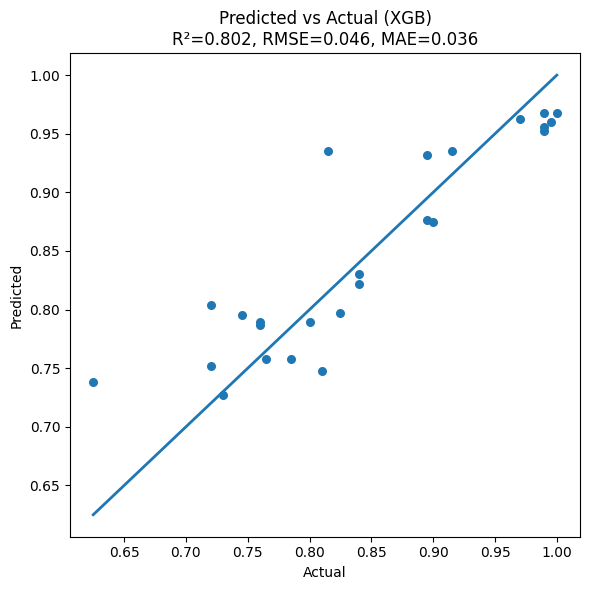

Saved: C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/pic_optuna\pred_vs_actual_optuna.png


In [9]:
best_params = study.best_params.copy()
best_params.update({
    "random_state": RANDOM_SEED,
    "tree_method": "hist",
    "n_jobs": max(1, os.cpu_count()-1),
    "eval_metric": "rmse",
})
best_model = XGBRegressor(**best_params)

X_tr, X_va, y_tr, y_va = train_test_split(
    X_train, y_train, test_size=0.1, random_state=RANDOM_SEED
)

best_model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

pred = best_model.predict(X_test)
r2   = r2_score(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)
mae  = mean_absolute_error(y_test, pred)
print(f"Test -> R²={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, s=30)
mn, mx = float(np.min(y_test)), float(np.max(y_test))
plt.plot([mn, mx], [mn, mx], lw=2)
plt.title(f"Predicted vs Actual (XGB)\nR²={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.tight_layout()
out_path = os.path.join(OUTDIR, "pred_vs_actual_optuna.png")
plt.savefig(out_path, dpi=150)
plt.show()
print("Saved:", out_path)


In [11]:
# # ===== 1) 用最优参数训练老师模型（可用全数据或训练集） =====
# best_params = study.best_params.copy()
# best_params.setdefault("tree_method", "hist")
# best_params.setdefault("random_state", RANDOM_SEED)

# X_all / y_all：建议用你训练时的同一份数据（或全量）来导出公式
# 如果你上面已经有 X_train, y_train，也可以先拼回 DataFrame/ndarray 全量:
# X_all, y_all = X, y  # 若你手里保留了完整 X, y
X_all, y_all = X_train, y_train  # 若你打算用训练折来导出公式

xgb_teacher = XGBRegressor(**best_params)
xgb_teacher.fit(X_all, y_all)

# ===== 2) 标准化特征（保存均值/方差，便于部署复现） =====
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xz = scaler.fit_transform(X_all)

# ===== 3) 线性蒸馏（把老师的预测作为回归目标），得到“公式” =====
from sklearn.linear_model import LinearRegression
teacher_pred = xgb_teacher.predict(X_all)

lin = LinearRegression().fit(Xz, teacher_pred)
NEW_INTERCEPT = float(lin.intercept_)
Z_COEFFS = dict(zip(FEATURES, map(float, lin.coef_)))

print("NEW_INTERCEPT =", NEW_INTERCEPT)
print("Z_COEFFS =", Z_COEFFS)

# ===== 4) （可选）导出“复杂度 = 1 - success_rate”的线性公式 =====
COMPLEXITY_INTERCEPT = 1.0 - NEW_INTERCEPT
COMPLEXITY_COEFFS = {k: -v for k, v in Z_COEFFS.items()}

print("COMPLEXITY_INTERCEPT =", COMPLEXITY_INTERCEPT)
print("COMPLEXITY_COEFFS =", COMPLEXITY_COEFFS)

# ===== 5) 保存到 JSON，连同 scaler 一起存（强烈建议）=====
import json, os
payload = {
    "target": TARGET_COL,                # 比如 "success_rate"
    "new_intercept": NEW_INTERCEPT,  # 线性蒸馏的截距
    "z_coeffs": Z_COEFFS,            # 标准化系数字典
    "complexity_intercept": COMPLEXITY_INTERCEPT,
    "complexity_coeffs": COMPLEXITY_COEFFS,
    "scaler": {                      # 用于推理时复现 z 分数
        "feature_order": FEATURES,
        "means": scaler.mean_.tolist(),
        "stds": scaler.scale_.tolist()
    },
    "xgb_best_params": best_params   # 记录老师超参
}
os.makedirs(OUTDIR, exist_ok=True)
with open(os.path.join(OUTDIR, "linear_formula_from_xgb.json"), "w", encoding="utf-8") as f:
    json.dump(payload, f, indent=2, ensure_ascii=False)
print("Saved ->", os.path.join(OUTDIR, "linear_formula_from_xgb.json"))


NEW_INTERCEPT = 0.8498563938534148
Z_COEFFS = {'size': -0.053114841431693365, 'num_agents': 0.2522555834547447, 'density': -0.024373645110113036, 'density_actual': -0.022860995775357107, 'LDD': -0.07455248304868833, 'BN': 0.04608927828640109, 'MC': 0.08999452177843661, 'DLR': 0.07483901107179369, 'FRA': 0.04616983038496823, 'FPA': 0.05103388422320293}
COMPLEXITY_INTERCEPT = 0.15014360614658517
COMPLEXITY_COEFFS = {'size': 0.053114841431693365, 'num_agents': -0.2522555834547447, 'density': 0.024373645110113036, 'density_actual': 0.022860995775357107, 'LDD': 0.07455248304868833, 'BN': -0.04608927828640109, 'MC': -0.08999452177843661, 'DLR': -0.07483901107179369, 'FRA': -0.04616983038496823, 'FPA': -0.05103388422320293}
Saved -> C:/Users/MSc_SEIoT_1/MAPF_G2RL-main - train/pic_optuna\linear_formula_from_xgb.json


In [ ]:
NEW_INTERCEPT = 0.8498563938534148
Z_COEFFS = {
    "size":           -0.053114841431693365,
    "num_agents":     +0.2522555834547447,
    "density":        -0.024373645110113036,
    "density_actual": -0.022860995775357107,
    "LDD":            -0.07455248304868833,
    "BN":             +0.04608927828640109,
    "MC":             +0.08999452177843661,
    "DLR":            +0.07483901107179369,
    "FRA":            +0.04616983038496823,
    "FPA":            +0.05103388422320293,
}
Z_FEATURE_KEYS = list(Z_COEFFS.keys())
# optuna complexity formula